In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

os.chdir("/disk/u/gio/mechinterp")

from src.utils.training_utils import get_device_map

model_key = "meta-llama/Llama-3.3-70B-Instruct"

device_map = get_device_map(model_key, 32, n_gpus=8)
print(device_map)

os.chdir("/disk/u/gio/mechinterp/analogies5")

from nnsight import LanguageModel

model_key = "meta-llama/Llama-3.3-70B-Instruct"

model = LanguageModel(
    model_key,
    device_map=device_map
)



INFO:__main__:torch.__version__='2.7.1+cu126', torch.version.cuda='12.6'
INFO:__main__:torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
INFO:__main__:transformers.__version__='4.54.1'
DEBUG:git.cmd:Popen(['git', 'version'], cwd=/disk/u/gio/mechinterp, stdin=None, shell=False, universal_newlines=False)
DEBUG:git.cmd:Popen(['git', 'version'], cwd=/disk/u/gio/mechinterp, stdin=None, shell=False, universal_newlines=False)
{'model.embed_tokens': 7, 'model.norm': 7, 'model.rotary_emb': 7, 'lm_head': 7, 'model.layers.0': 0, 'model.layers.1': 1, 'model.layers.2': 2, 'model.layers.3': 3, 'model.layers.4': 4, 'model.layers.5': 5, 'model.layers.6': 6, 'model.layers.7': 7, 'model.layers.8': 0, 'model.layers.9': 1, 'model.layers.10': 2, 'model.layers.11': 3, 'model.layers.12': 4, 'model.layers.13': 5, 'model.layers.14': 6, 'model.layers.15': 7, 'model.layers.16': 0, 'model.layers.17': 1, 'model.layers.18': 2, 'model.layers.19': 3, 'mo

In [3]:
os.getcwd()

'/disk/u/gio/mechinterp/analogies5'

## Resdiual Activation Patching

### Source Run

In [4]:
# Add the analogies5 directory to Python path so we can import from src
import sys
sys.path.append("/disk/u/gio/mechinterp/analogies5")

from src.intervention.analysis import collect_activations, collect_logits

source_prompt = """The sculpture is crafted out of clay.
The sculpture is inside the gallery.
The vase is made of marble.
The vase is housed in the park.
sculpture is to vase as clay is to"""

source_activations = collect_activations(
    model,
    source_prompt,
    kind="residual"
)
source_logits = collect_logits(
    model,
    source_prompt
)

  0%|          | 0/80 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0


100%|██████████| 80/80 [02:42<00:00,  2.03s/it]  


In [5]:
source_pred_id = source_logits[-1].argmax(dim=-1)
source_pred_tok = model.tokenizer.decode(source_pred_id)
print("Source Prediction:", source_pred_tok)

Source Prediction:  marble


### Base Run

In [6]:
base_prompt = """The sculpture is crafted out of clay.
The sculpture is inside the gallery.
The vase is made of marble.
The vase is housed in the park.
sculpture is to vase as gallery is to"""

base_activations = collect_activations(
    model,
    base_prompt,
    kind="residual"
)
base_logits = collect_logits(
    model,
    base_prompt
)

100%|██████████| 80/80 [00:43<00:00,  1.84it/s]


In [7]:
base_pred_id = base_logits[-1].argmax(dim=-1)
base_pred_tok = model.tokenizer.decode(base_pred_id)
print("Base Prediction:", base_pred_tok)

Base Prediction:  park


In [11]:
source_target_logits = source_logits[-1][source_pred_id]
source_target_logits_base = base_logits[-1][source_pred_id]

total_logit_diff = source_target_logits - source_target_logits_base
print(f"{total_logit_diff=}")

total_logit_diff=tensor(8.0037, device='cuda:7', grad_fn=<SubBackward0>)


In [12]:
source_input_ids = model.tokenizer.encode(source_prompt)
base_input_ids = model.tokenizer.encode(base_prompt)

assert len(source_input_ids) == len(base_input_ids)

In [16]:
source_activations[0].shape

torch.Size([41, 8192])

### Patched Run

In [18]:
from tqdm import trange

patched_activations = []

# Loop through the model layers
for l in trange(model.config.num_hidden_layers):

    patch_at_layer = []

    # For each token position
    for t in range(len(source_input_ids)):

        # We run the model on the base prompt
        with model.trace(base_prompt) as tracer:

            # Replace the residual stream output with the source_activations at that token
            model.model.layers[l].output[0][t, :] = source_activations[l][t, :]

            # Get the model output logits
            patched_logits = model.output.logits[0].save()

            # Get the logits for the source target
            patched_target_logits = patched_logits[-1, source_pred_id].item().save()

            # Calculate the logit difference
            logit_diff = patched_target_logits - source_target_logits_base

            # Normalize the logit difference
            if total_logit_diff == 0:
                normalized_score = 0.0
            else:
                normalized_score = logit_diff / total_logit_diff

            normalized_score = normalized_score.save()

        # Print the layer, token, and logit difference
        print(f"L{l}, T{t}, LD={normalized_score}")

        # Append the token to our list of logit differences at the current layer
        patch_at_layer.append(normalized_score)
    
    # Append each layer's logit differences list to our overall list of lists
    patched_activations.append(patch_at_layer)

print(f"\\nPatched activations shape: {len(patched_activations)} layers x {len(patched_activations[0])} tokens")


  0%|          | 0/80 [00:00<?, ?it/s]

L0, T0, LD=0.0
L0, T1, LD=0.0
L0, T2, LD=0.0
L0, T3, LD=0.0
L0, T4, LD=0.0
L0, T5, LD=0.0
L0, T6, LD=0.0
L0, T7, LD=0.0
L0, T8, LD=0.0
L0, T9, LD=0.0
L0, T10, LD=0.0
L0, T11, LD=0.0
L0, T12, LD=0.0
L0, T13, LD=0.0
L0, T14, LD=0.0
L0, T15, LD=0.0
L0, T16, LD=0.0
L0, T17, LD=0.0
L0, T18, LD=0.0
L0, T19, LD=0.0
L0, T20, LD=0.0
L0, T21, LD=0.0
L0, T22, LD=0.0
L0, T23, LD=0.0
L0, T24, LD=0.0
L0, T25, LD=0.0
L0, T26, LD=0.0
L0, T27, LD=0.0
L0, T28, LD=0.0
L0, T29, LD=0.0
L0, T30, LD=0.0
L0, T31, LD=0.0
L0, T32, LD=0.0
L0, T33, LD=0.0
L0, T34, LD=0.0
L0, T35, LD=0.0
L0, T36, LD=0.0
L0, T37, LD=0.0
L0, T38, LD=1.0004549026489258
L0, T39, LD=-0.0015501880552619696


  1%|▏         | 1/80 [00:22<30:13, 22.96s/it]

L0, T40, LD=-0.00015918917779345065
L1, T0, LD=0.0
L1, T1, LD=0.0
L1, T2, LD=0.0
L1, T3, LD=0.0
L1, T4, LD=0.0
L1, T5, LD=0.0
L1, T6, LD=0.0
L1, T7, LD=0.0
L1, T8, LD=0.0
L1, T9, LD=0.0
L1, T10, LD=0.0
L1, T11, LD=0.0
L1, T12, LD=0.0
L1, T13, LD=0.0
L1, T14, LD=0.0
L1, T15, LD=0.0
L1, T16, LD=0.0
L1, T17, LD=0.0
L1, T18, LD=0.0
L1, T19, LD=0.0
L1, T20, LD=0.0
L1, T21, LD=0.0
L1, T22, LD=0.0
L1, T23, LD=0.0
L1, T24, LD=0.0
L1, T25, LD=0.0
L1, T26, LD=0.0
L1, T27, LD=0.0
L1, T28, LD=0.0
L1, T29, LD=0.0
L1, T30, LD=0.0
L1, T31, LD=0.0
L1, T32, LD=0.0
L1, T33, LD=0.0
L1, T34, LD=0.0
L1, T35, LD=0.0
L1, T36, LD=0.0
L1, T37, LD=0.0
L1, T38, LD=1.0009169578552246
L1, T39, LD=-0.001854744623415172


  2%|▎         | 2/80 [00:45<29:42, 22.86s/it]

L1, T40, LD=-0.0009276106138713658
L2, T0, LD=0.0
L2, T1, LD=0.0
L2, T2, LD=0.0
L2, T3, LD=0.0
L2, T4, LD=0.0
L2, T5, LD=0.0
L2, T6, LD=0.0
L2, T7, LD=0.0
L2, T8, LD=0.0
L2, T9, LD=0.0
L2, T10, LD=0.0
L2, T11, LD=0.0
L2, T12, LD=0.0
L2, T13, LD=0.0
L2, T14, LD=0.0
L2, T15, LD=0.0
L2, T16, LD=0.0
L2, T17, LD=0.0
L2, T18, LD=0.0
L2, T19, LD=0.0
L2, T20, LD=0.0
L2, T21, LD=0.0
L2, T22, LD=0.0
L2, T23, LD=0.0
L2, T24, LD=0.0
L2, T25, LD=0.0
L2, T26, LD=0.0
L2, T27, LD=0.0
L2, T28, LD=0.0
L2, T29, LD=0.0
L2, T30, LD=0.0
L2, T31, LD=0.0
L2, T32, LD=0.0
L2, T33, LD=0.0
L2, T34, LD=0.0
L2, T35, LD=0.0
L2, T36, LD=0.0
L2, T37, LD=0.0
L2, T38, LD=1.0013846158981323
L2, T39, LD=-0.004612673539668322


  4%|▍         | 3/80 [01:08<29:17, 22.82s/it]

L2, T40, LD=-3.0384162528207526e-05
L3, T0, LD=0.0
L3, T1, LD=0.0
L3, T2, LD=0.0
L3, T3, LD=0.0
L3, T4, LD=0.0
L3, T5, LD=0.0
L3, T6, LD=0.0
L3, T7, LD=0.0
L3, T8, LD=0.0
L3, T9, LD=0.0
L3, T10, LD=0.0
L3, T11, LD=0.0
L3, T12, LD=0.0
L3, T13, LD=0.0
L3, T14, LD=0.0
L3, T15, LD=0.0
L3, T16, LD=0.0
L3, T17, LD=0.0
L3, T18, LD=0.0
L3, T19, LD=0.0
L3, T20, LD=0.0
L3, T21, LD=0.0
L3, T22, LD=0.0
L3, T23, LD=0.0
L3, T24, LD=0.0
L3, T25, LD=0.0
L3, T26, LD=0.0
L3, T27, LD=0.0
L3, T28, LD=0.0
L3, T29, LD=0.0
L3, T30, LD=0.0
L3, T31, LD=0.0
L3, T32, LD=0.0
L3, T33, LD=0.0
L3, T34, LD=0.0
L3, T35, LD=0.0
L3, T36, LD=0.0
L3, T37, LD=0.0
L3, T38, LD=1.000851035118103
L3, T39, LD=-0.002443959005177021


  5%|▌         | 4/80 [01:31<28:53, 22.81s/it]

L3, T40, LD=-0.0006079215672798455
L4, T0, LD=0.0
L4, T1, LD=0.0
L4, T2, LD=0.0
L4, T3, LD=0.0
L4, T4, LD=0.0
L4, T5, LD=0.0
L4, T6, LD=0.0
L4, T7, LD=0.0
L4, T8, LD=0.0
L4, T9, LD=0.0
L4, T10, LD=0.0
L4, T11, LD=0.0
L4, T12, LD=0.0
L4, T13, LD=0.0
L4, T14, LD=0.0
L4, T15, LD=0.0
L4, T16, LD=0.0
L4, T17, LD=0.0
L4, T18, LD=0.0
L4, T19, LD=0.0
L4, T20, LD=0.0
L4, T21, LD=0.0
L4, T22, LD=0.0
L4, T23, LD=0.0
L4, T24, LD=0.0
L4, T25, LD=0.0
L4, T26, LD=0.0
L4, T27, LD=0.0
L4, T28, LD=0.0
L4, T29, LD=0.0
L4, T30, LD=0.0
L4, T31, LD=0.0
L4, T32, LD=0.0
L4, T33, LD=0.0
L4, T34, LD=0.0
L4, T35, LD=0.0
L4, T36, LD=0.0
L4, T37, LD=0.0
L4, T38, LD=1.0018492937088013
L4, T39, LD=-0.008698330260813236


  6%|▋         | 5/80 [01:54<28:30, 22.81s/it]

L4, T40, LD=0.000197437489987351
L5, T0, LD=0.0
L5, T1, LD=0.0
L5, T2, LD=0.0
L5, T3, LD=0.0
L5, T4, LD=0.0
L5, T5, LD=0.0
L5, T6, LD=0.0
L5, T7, LD=0.0
L5, T8, LD=0.0
L5, T9, LD=0.0
L5, T10, LD=0.0
L5, T11, LD=0.0
L5, T12, LD=0.0
L5, T13, LD=0.0
L5, T14, LD=0.0
L5, T15, LD=0.0
L5, T16, LD=0.0
L5, T17, LD=0.0
L5, T18, LD=0.0
L5, T19, LD=0.0
L5, T20, LD=0.0
L5, T21, LD=0.0
L5, T22, LD=0.0
L5, T23, LD=0.0
L5, T24, LD=0.0
L5, T25, LD=0.0
L5, T26, LD=0.0
L5, T27, LD=0.0
L5, T28, LD=0.0
L5, T29, LD=0.0
L5, T30, LD=0.0
L5, T31, LD=0.0
L5, T32, LD=0.0
L5, T33, LD=0.0
L5, T34, LD=0.0
L5, T35, LD=0.0
L5, T36, LD=0.0
L5, T37, LD=0.0
L5, T38, LD=1.0025300979614258
L5, T39, LD=-0.007903337478637695


  8%|▊         | 6/80 [02:16<28:07, 22.80s/it]

L5, T40, LD=-0.0010377084836363792
L6, T0, LD=0.0
L6, T1, LD=0.0
L6, T2, LD=0.0
L6, T3, LD=0.0
L6, T4, LD=0.0
L6, T5, LD=0.0
L6, T6, LD=0.0
L6, T7, LD=0.0
L6, T8, LD=0.0
L6, T9, LD=0.0
L6, T10, LD=0.0
L6, T11, LD=0.0
L6, T12, LD=0.0
L6, T13, LD=0.0
L6, T14, LD=0.0
L6, T15, LD=0.0
L6, T16, LD=0.0
L6, T17, LD=0.0
L6, T18, LD=0.0
L6, T19, LD=0.0
L6, T20, LD=0.0
L6, T21, LD=0.0
L6, T22, LD=0.0
L6, T23, LD=0.0
L6, T24, LD=0.0
L6, T25, LD=0.0
L6, T26, LD=0.0
L6, T27, LD=0.0
L6, T28, LD=0.0
L6, T29, LD=0.0
L6, T30, LD=0.0
L6, T31, LD=0.0
L6, T32, LD=0.0
L6, T33, LD=0.0
L6, T34, LD=0.0
L6, T35, LD=0.0
L6, T36, LD=0.0
L6, T37, LD=0.0
L6, T38, LD=1.004089117050171
L6, T39, LD=-0.005125272087752819


  9%|▉         | 7/80 [02:39<27:48, 22.85s/it]

L6, T40, LD=0.0007331519736908376
L7, T0, LD=0.0
L7, T1, LD=0.0
L7, T2, LD=0.0
L7, T3, LD=0.0
L7, T4, LD=0.0
L7, T5, LD=0.0
L7, T6, LD=0.0
L7, T7, LD=0.0
L7, T8, LD=0.0
L7, T9, LD=0.0
L7, T10, LD=0.0
L7, T11, LD=0.0
L7, T12, LD=0.0
L7, T13, LD=0.0
L7, T14, LD=0.0
L7, T15, LD=0.0
L7, T16, LD=0.0
L7, T17, LD=0.0
L7, T18, LD=0.0
L7, T19, LD=0.0
L7, T20, LD=0.0
L7, T21, LD=0.0
L7, T22, LD=0.0
L7, T23, LD=0.0
L7, T24, LD=0.0
L7, T25, LD=0.0
L7, T26, LD=0.0
L7, T27, LD=0.0
L7, T28, LD=0.0
L7, T29, LD=0.0
L7, T30, LD=0.0
L7, T31, LD=0.0
L7, T32, LD=0.0
L7, T33, LD=0.0
L7, T34, LD=0.0
L7, T35, LD=0.0
L7, T36, LD=0.0
L7, T37, LD=0.0
L7, T38, LD=1.0055272579193115
L7, T39, LD=-0.006848947610706091


 10%|█         | 8/80 [03:02<27:23, 22.83s/it]

L7, T40, LD=0.0015277871862053871
L8, T0, LD=0.0
L8, T1, LD=0.0
L8, T2, LD=0.0
L8, T3, LD=0.0
L8, T4, LD=0.0
L8, T5, LD=0.0
L8, T6, LD=0.0
L8, T7, LD=0.0
L8, T8, LD=0.0
L8, T9, LD=0.0
L8, T10, LD=0.0
L8, T11, LD=0.0
L8, T12, LD=0.0
L8, T13, LD=0.0
L8, T14, LD=0.0
L8, T15, LD=0.0
L8, T16, LD=0.0
L8, T17, LD=0.0
L8, T18, LD=0.0
L8, T19, LD=0.0
L8, T20, LD=0.0
L8, T21, LD=0.0
L8, T22, LD=0.0
L8, T23, LD=0.0
L8, T24, LD=0.0
L8, T25, LD=0.0
L8, T26, LD=0.0
L8, T27, LD=0.0
L8, T28, LD=0.0
L8, T29, LD=0.0
L8, T30, LD=0.0
L8, T31, LD=0.0
L8, T32, LD=0.0
L8, T33, LD=0.0
L8, T34, LD=0.0
L8, T35, LD=0.0
L8, T36, LD=0.0
L8, T37, LD=0.0
L8, T38, LD=1.0058306455612183
L8, T39, LD=-0.014100396074354649


 11%|█▏        | 9/80 [03:25<27:00, 22.83s/it]

L8, T40, LD=0.006806648336350918
L9, T0, LD=0.0
L9, T1, LD=0.0
L9, T2, LD=0.0
L9, T3, LD=0.0
L9, T4, LD=0.0
L9, T5, LD=0.0
L9, T6, LD=0.0
L9, T7, LD=0.0
L9, T8, LD=0.0
L9, T9, LD=0.0
L9, T10, LD=0.0
L9, T11, LD=0.0
L9, T12, LD=0.0
L9, T13, LD=0.0
L9, T14, LD=0.0
L9, T15, LD=0.0
L9, T16, LD=0.0
L9, T17, LD=0.0
L9, T18, LD=0.0
L9, T19, LD=0.0
L9, T20, LD=0.0
L9, T21, LD=0.0
L9, T22, LD=0.0
L9, T23, LD=0.0
L9, T24, LD=0.0
L9, T25, LD=0.0
L9, T26, LD=0.0
L9, T27, LD=0.0
L9, T28, LD=0.0
L9, T29, LD=0.0
L9, T30, LD=0.0
L9, T31, LD=0.0
L9, T32, LD=0.0
L9, T33, LD=0.0
L9, T34, LD=0.0
L9, T35, LD=0.0
L9, T36, LD=0.0
L9, T37, LD=0.0
L9, T38, LD=1.0089424848556519
L9, T39, LD=-0.019728615880012512


 12%|█▎        | 10/80 [03:48<26:37, 22.82s/it]

L9, T40, LD=-0.00010008900426328182
L10, T0, LD=0.0
L10, T1, LD=0.0
L10, T2, LD=0.0
L10, T3, LD=0.0
L10, T4, LD=0.0
L10, T5, LD=0.0
L10, T6, LD=0.0
L10, T7, LD=0.0
L10, T8, LD=0.0
L10, T9, LD=0.0
L10, T10, LD=0.0
L10, T11, LD=0.0
L10, T12, LD=0.0
L10, T13, LD=0.0
L10, T14, LD=0.0
L10, T15, LD=0.0
L10, T16, LD=0.0
L10, T17, LD=0.0
L10, T18, LD=0.0
L10, T19, LD=0.0
L10, T20, LD=0.0
L10, T21, LD=0.0
L10, T22, LD=0.0
L10, T23, LD=0.0
L10, T24, LD=0.0
L10, T25, LD=0.0
L10, T26, LD=0.0
L10, T27, LD=0.0
L10, T28, LD=0.0
L10, T29, LD=0.0
L10, T30, LD=0.0
L10, T31, LD=0.0
L10, T32, LD=0.0
L10, T33, LD=0.0
L10, T34, LD=0.0
L10, T35, LD=0.0
L10, T36, LD=0.0
L10, T37, LD=0.0
L10, T38, LD=1.0089694261550903
L10, T39, LD=-0.020308654755353928


 14%|█▍        | 11/80 [04:11<26:14, 22.81s/it]

L10, T40, LD=0.0011545981978997588
L11, T0, LD=0.0
L11, T1, LD=0.0
L11, T2, LD=0.0
L11, T3, LD=0.0
L11, T4, LD=0.0
L11, T5, LD=0.0
L11, T6, LD=0.0
L11, T7, LD=0.0
L11, T8, LD=0.0
L11, T9, LD=0.0
L11, T10, LD=0.0
L11, T11, LD=0.0
L11, T12, LD=0.0
L11, T13, LD=0.0
L11, T14, LD=0.0
L11, T15, LD=0.0
L11, T16, LD=0.0
L11, T17, LD=0.0
L11, T18, LD=0.0
L11, T19, LD=0.0
L11, T20, LD=0.0
L11, T21, LD=0.0
L11, T22, LD=0.0
L11, T23, LD=0.0
L11, T24, LD=0.0
L11, T25, LD=0.0
L11, T26, LD=0.0
L11, T27, LD=0.0
L11, T28, LD=0.0
L11, T29, LD=0.0
L11, T30, LD=0.0
L11, T31, LD=0.0
L11, T32, LD=0.0
L11, T33, LD=0.0
L11, T34, LD=0.0
L11, T35, LD=0.0
L11, T36, LD=0.0
L11, T37, LD=0.0
L11, T38, LD=1.0103737115859985
L11, T39, LD=-0.02032092772424221


 15%|█▌        | 12/80 [04:33<25:50, 22.81s/it]

L11, T40, LD=0.002297519240528345
L12, T0, LD=0.0
L12, T1, LD=0.0
L12, T2, LD=0.0
L12, T3, LD=0.0
L12, T4, LD=0.0
L12, T5, LD=0.0
L12, T6, LD=0.0
L12, T7, LD=0.0
L12, T8, LD=0.0
L12, T9, LD=0.0
L12, T10, LD=0.0
L12, T11, LD=0.0
L12, T12, LD=0.0
L12, T13, LD=0.0
L12, T14, LD=0.0
L12, T15, LD=0.0
L12, T16, LD=0.0
L12, T17, LD=0.0
L12, T18, LD=0.0
L12, T19, LD=0.0
L12, T20, LD=0.0
L12, T21, LD=0.0
L12, T22, LD=0.0
L12, T23, LD=0.0
L12, T24, LD=0.0
L12, T25, LD=0.0
L12, T26, LD=0.0
L12, T27, LD=0.0
L12, T28, LD=0.0
L12, T29, LD=0.0
L12, T30, LD=0.0
L12, T31, LD=0.0
L12, T32, LD=0.0
L12, T33, LD=0.0
L12, T34, LD=0.0
L12, T35, LD=0.0
L12, T36, LD=0.0
L12, T37, LD=0.0
L12, T38, LD=1.0092089176177979
L12, T39, LD=-0.023774119094014168


 16%|█▋        | 13/80 [04:56<25:31, 22.85s/it]

L12, T40, LD=0.0028369275387376547
L13, T0, LD=0.0
L13, T1, LD=0.0
L13, T2, LD=0.0
L13, T3, LD=0.0
L13, T4, LD=0.0
L13, T5, LD=0.0
L13, T6, LD=0.0
L13, T7, LD=0.0
L13, T8, LD=0.0
L13, T9, LD=0.0
L13, T10, LD=0.0
L13, T11, LD=0.0
L13, T12, LD=0.0
L13, T13, LD=0.0
L13, T14, LD=0.0
L13, T15, LD=0.0
L13, T16, LD=0.0
L13, T17, LD=0.0
L13, T18, LD=0.0
L13, T19, LD=0.0
L13, T20, LD=0.0
L13, T21, LD=0.0
L13, T22, LD=0.0
L13, T23, LD=0.0
L13, T24, LD=0.0
L13, T25, LD=0.0
L13, T26, LD=0.0
L13, T27, LD=0.0
L13, T28, LD=0.0
L13, T29, LD=0.0
L13, T30, LD=0.0
L13, T31, LD=0.0
L13, T32, LD=0.0
L13, T33, LD=0.0
L13, T34, LD=0.0
L13, T35, LD=0.0
L13, T36, LD=0.0
L13, T37, LD=0.0
L13, T38, LD=1.0107474327087402
L13, T39, LD=-0.03651032596826553


 18%|█▊        | 14/80 [05:19<25:07, 22.84s/it]

L13, T40, LD=0.02236691489815712
L14, T0, LD=0.0
L14, T1, LD=0.0
L14, T2, LD=0.0
L14, T3, LD=0.0
L14, T4, LD=0.0
L14, T5, LD=0.0
L14, T6, LD=0.0
L14, T7, LD=0.0
L14, T8, LD=0.0
L14, T9, LD=0.0
L14, T10, LD=0.0
L14, T11, LD=0.0
L14, T12, LD=0.0
L14, T13, LD=0.0
L14, T14, LD=0.0
L14, T15, LD=0.0
L14, T16, LD=0.0
L14, T17, LD=0.0
L14, T18, LD=0.0
L14, T19, LD=0.0
L14, T20, LD=0.0
L14, T21, LD=0.0
L14, T22, LD=0.0
L14, T23, LD=0.0
L14, T24, LD=0.0
L14, T25, LD=0.0
L14, T26, LD=0.0
L14, T27, LD=0.0
L14, T28, LD=0.0
L14, T29, LD=0.0
L14, T30, LD=0.0
L14, T31, LD=0.0
L14, T32, LD=0.0
L14, T33, LD=0.0
L14, T34, LD=0.0
L14, T35, LD=0.0
L14, T36, LD=0.0
L14, T37, LD=0.0
L14, T38, LD=1.0154037475585938
L14, T39, LD=-0.036735646426677704


 19%|█▉        | 15/80 [05:42<24:43, 22.82s/it]

L14, T40, LD=0.02723505347967148
L15, T0, LD=0.0
L15, T1, LD=0.0
L15, T2, LD=0.0
L15, T3, LD=0.0
L15, T4, LD=0.0
L15, T5, LD=0.0
L15, T6, LD=0.0
L15, T7, LD=0.0
L15, T8, LD=0.0
L15, T9, LD=0.0
L15, T10, LD=0.0
L15, T11, LD=0.0
L15, T12, LD=0.0
L15, T13, LD=0.0
L15, T14, LD=0.0
L15, T15, LD=0.0
L15, T16, LD=0.0
L15, T17, LD=0.0
L15, T18, LD=0.0
L15, T19, LD=0.0
L15, T20, LD=0.0
L15, T21, LD=0.0
L15, T22, LD=0.0
L15, T23, LD=0.0
L15, T24, LD=0.0
L15, T25, LD=0.0
L15, T26, LD=0.0
L15, T27, LD=0.0
L15, T28, LD=0.0
L15, T29, LD=0.0
L15, T30, LD=0.0
L15, T31, LD=0.0
L15, T32, LD=0.0
L15, T33, LD=0.0
L15, T34, LD=0.0
L15, T35, LD=0.0
L15, T36, LD=0.0
L15, T37, LD=0.0
L15, T38, LD=1.0203187465667725
L15, T39, LD=-0.04863086715340614


 20%|██        | 16/80 [06:05<24:19, 22.81s/it]

L15, T40, LD=0.026991622522473335
L16, T0, LD=0.0
L16, T1, LD=0.0
L16, T2, LD=0.0
L16, T3, LD=0.0
L16, T4, LD=0.0
L16, T5, LD=0.0
L16, T6, LD=0.0
L16, T7, LD=0.0
L16, T8, LD=0.0
L16, T9, LD=0.0
L16, T10, LD=0.0
L16, T11, LD=0.0
L16, T12, LD=0.0
L16, T13, LD=0.0
L16, T14, LD=0.0
L16, T15, LD=0.0
L16, T16, LD=0.0
L16, T17, LD=0.0
L16, T18, LD=0.0
L16, T19, LD=0.0
L16, T20, LD=0.0
L16, T21, LD=0.0
L16, T22, LD=0.0
L16, T23, LD=0.0
L16, T24, LD=0.0
L16, T25, LD=0.0
L16, T26, LD=0.0
L16, T27, LD=0.0
L16, T28, LD=0.0
L16, T29, LD=0.0
L16, T30, LD=0.0
L16, T31, LD=0.0
L16, T32, LD=0.0
L16, T33, LD=0.0
L16, T34, LD=0.0
L16, T35, LD=0.0
L16, T36, LD=0.0
L16, T37, LD=0.0
L16, T38, LD=1.0223183631896973
L16, T39, LD=-0.04520532116293907


 21%|██▏       | 17/80 [06:27<23:56, 22.80s/it]

L16, T40, LD=0.02097567729651928
L17, T0, LD=0.0
L17, T1, LD=0.0
L17, T2, LD=0.0
L17, T3, LD=0.0
L17, T4, LD=0.0
L17, T5, LD=0.0
L17, T6, LD=0.0
L17, T7, LD=0.0
L17, T8, LD=0.0
L17, T9, LD=0.0
L17, T10, LD=0.0
L17, T11, LD=0.0
L17, T12, LD=0.0
L17, T13, LD=0.0
L17, T14, LD=0.0
L17, T15, LD=0.0
L17, T16, LD=0.0
L17, T17, LD=0.0
L17, T18, LD=0.0
L17, T19, LD=0.0
L17, T20, LD=0.0
L17, T21, LD=0.0
L17, T22, LD=0.0
L17, T23, LD=0.0
L17, T24, LD=0.0
L17, T25, LD=0.0
L17, T26, LD=0.0
L17, T27, LD=0.0
L17, T28, LD=0.0
L17, T29, LD=0.0
L17, T30, LD=0.0
L17, T31, LD=0.0
L17, T32, LD=0.0
L17, T33, LD=0.0
L17, T34, LD=0.0
L17, T35, LD=0.0
L17, T36, LD=0.0
L17, T37, LD=0.0
L17, T38, LD=1.0206178426742554
L17, T39, LD=-0.04451220482587814


 22%|██▎       | 18/80 [06:50<23:33, 22.80s/it]

L17, T40, LD=-0.00048138046986423433
L18, T0, LD=0.0
L18, T1, LD=0.0
L18, T2, LD=0.0
L18, T3, LD=0.0
L18, T4, LD=0.0
L18, T5, LD=0.0
L18, T6, LD=0.0
L18, T7, LD=0.0
L18, T8, LD=0.0
L18, T9, LD=0.0
L18, T10, LD=0.0
L18, T11, LD=0.0
L18, T12, LD=0.0
L18, T13, LD=0.0
L18, T14, LD=0.0
L18, T15, LD=0.0
L18, T16, LD=0.0
L18, T17, LD=0.0
L18, T18, LD=0.0
L18, T19, LD=0.0
L18, T20, LD=0.0
L18, T21, LD=0.0
L18, T22, LD=0.0
L18, T23, LD=0.0
L18, T24, LD=0.0
L18, T25, LD=0.0
L18, T26, LD=0.0
L18, T27, LD=0.0
L18, T28, LD=0.0
L18, T29, LD=0.0
L18, T30, LD=0.0
L18, T31, LD=0.0
L18, T32, LD=0.0
L18, T33, LD=0.0
L18, T34, LD=0.0
L18, T35, LD=0.0
L18, T36, LD=0.0
L18, T37, LD=0.0
L18, T38, LD=1.0178709030151367
L18, T39, LD=-0.03135848045349121


 24%|██▍       | 19/80 [07:13<23:14, 22.87s/it]

L18, T40, LD=0.02325139194726944
L19, T0, LD=0.0
L19, T1, LD=0.0
L19, T2, LD=0.0
L19, T3, LD=0.0
L19, T4, LD=0.0
L19, T5, LD=0.0
L19, T6, LD=0.0
L19, T7, LD=0.0
L19, T8, LD=0.0
L19, T9, LD=0.0
L19, T10, LD=0.0
L19, T11, LD=0.0
L19, T12, LD=0.0
L19, T13, LD=0.0
L19, T14, LD=0.0
L19, T15, LD=0.0
L19, T16, LD=0.0
L19, T17, LD=0.0
L19, T18, LD=0.0
L19, T19, LD=0.0
L19, T20, LD=0.0
L19, T21, LD=0.0
L19, T22, LD=0.0
L19, T23, LD=0.0
L19, T24, LD=0.0
L19, T25, LD=0.0
L19, T26, LD=0.0
L19, T27, LD=0.0
L19, T28, LD=0.0
L19, T29, LD=0.0
L19, T30, LD=0.0
L19, T31, LD=0.0
L19, T32, LD=0.0
L19, T33, LD=0.0
L19, T34, LD=0.0
L19, T35, LD=0.0
L19, T36, LD=0.0
L19, T37, LD=0.0
L19, T38, LD=1.0160375833511353
L19, T39, LD=-0.03708178550004959


 25%|██▌       | 20/80 [07:36<22:51, 22.85s/it]

L19, T40, LD=0.03886646777391434
L20, T0, LD=0.0
L20, T1, LD=0.0
L20, T2, LD=0.0
L20, T3, LD=0.0
L20, T4, LD=0.0
L20, T5, LD=0.0
L20, T6, LD=0.0
L20, T7, LD=0.0
L20, T8, LD=0.0
L20, T9, LD=0.0
L20, T10, LD=0.0
L20, T11, LD=0.0
L20, T12, LD=0.0
L20, T13, LD=0.0
L20, T14, LD=0.0
L20, T15, LD=0.0
L20, T16, LD=0.0
L20, T17, LD=0.0
L20, T18, LD=0.0
L20, T19, LD=0.0
L20, T20, LD=0.0
L20, T21, LD=0.0
L20, T22, LD=0.0
L20, T23, LD=0.0
L20, T24, LD=0.0
L20, T25, LD=0.0
L20, T26, LD=0.0
L20, T27, LD=0.0
L20, T28, LD=0.0
L20, T29, LD=0.0
L20, T30, LD=0.0
L20, T31, LD=0.0
L20, T32, LD=0.0
L20, T33, LD=0.0
L20, T34, LD=0.0
L20, T35, LD=0.0
L20, T36, LD=0.0
L20, T37, LD=0.0
L20, T38, LD=1.0126445293426514
L20, T39, LD=-0.03191421553492546


 26%|██▋       | 21/80 [07:59<22:27, 22.84s/it]

L20, T40, LD=0.059615395963191986
L21, T0, LD=0.0
L21, T1, LD=0.0
L21, T2, LD=0.0
L21, T3, LD=0.0
L21, T4, LD=0.0
L21, T5, LD=0.0
L21, T6, LD=0.0
L21, T7, LD=0.0
L21, T8, LD=0.0
L21, T9, LD=0.0
L21, T10, LD=0.0
L21, T11, LD=0.0
L21, T12, LD=0.0
L21, T13, LD=0.0
L21, T14, LD=0.0
L21, T15, LD=0.0
L21, T16, LD=0.0
L21, T17, LD=0.0
L21, T18, LD=0.0
L21, T19, LD=0.0
L21, T20, LD=0.0
L21, T21, LD=0.0
L21, T22, LD=0.0
L21, T23, LD=0.0
L21, T24, LD=0.0
L21, T25, LD=0.0
L21, T26, LD=0.0
L21, T27, LD=0.0
L21, T28, LD=0.0
L21, T29, LD=0.0
L21, T30, LD=0.0
L21, T31, LD=0.0
L21, T32, LD=0.0
L21, T33, LD=0.0
L21, T34, LD=0.0
L21, T35, LD=0.0
L21, T36, LD=0.0
L21, T37, LD=0.0
L21, T38, LD=1.01065993309021
L21, T39, LD=-0.0024960292503237724


 28%|██▊       | 22/80 [08:22<22:04, 22.83s/it]

L21, T40, LD=0.08659534156322479
L22, T0, LD=0.0
L22, T1, LD=0.0
L22, T2, LD=0.0
L22, T3, LD=0.0
L22, T4, LD=0.0
L22, T5, LD=0.0
L22, T6, LD=0.0
L22, T7, LD=0.0
L22, T8, LD=0.0
L22, T9, LD=0.0
L22, T10, LD=0.0
L22, T11, LD=0.0
L22, T12, LD=0.0
L22, T13, LD=0.0
L22, T14, LD=0.0
L22, T15, LD=0.0
L22, T16, LD=0.0
L22, T17, LD=0.0
L22, T18, LD=0.0
L22, T19, LD=0.0
L22, T20, LD=0.0
L22, T21, LD=0.0
L22, T22, LD=0.0
L22, T23, LD=0.0
L22, T24, LD=0.0
L22, T25, LD=0.0
L22, T26, LD=0.0
L22, T27, LD=0.0
L22, T28, LD=0.0
L22, T29, LD=0.0
L22, T30, LD=0.0
L22, T31, LD=0.0
L22, T32, LD=0.0
L22, T33, LD=0.0
L22, T34, LD=0.0
L22, T35, LD=0.0
L22, T36, LD=0.0
L22, T37, LD=0.0
L22, T38, LD=1.0124300718307495
L22, T39, LD=0.033760737627744675


 29%|██▉       | 23/80 [08:45<21:40, 22.82s/it]

L22, T40, LD=0.1102050244808197
L23, T0, LD=0.0
L23, T1, LD=0.0
L23, T2, LD=0.0
L23, T3, LD=0.0
L23, T4, LD=0.0
L23, T5, LD=0.0
L23, T6, LD=0.0
L23, T7, LD=0.0
L23, T8, LD=0.0
L23, T9, LD=0.0
L23, T10, LD=0.0
L23, T11, LD=0.0
L23, T12, LD=0.0
L23, T13, LD=0.0
L23, T14, LD=0.0
L23, T15, LD=0.0
L23, T16, LD=0.0
L23, T17, LD=0.0
L23, T18, LD=0.0
L23, T19, LD=0.0
L23, T20, LD=0.0
L23, T21, LD=0.0
L23, T22, LD=0.0
L23, T23, LD=0.0
L23, T24, LD=0.0
L23, T25, LD=0.0
L23, T26, LD=0.0
L23, T27, LD=0.0
L23, T28, LD=0.0
L23, T29, LD=0.0
L23, T30, LD=0.0
L23, T31, LD=0.0
L23, T32, LD=0.0
L23, T33, LD=0.0
L23, T34, LD=0.0
L23, T35, LD=0.0
L23, T36, LD=0.0
L23, T37, LD=0.0
L23, T38, LD=1.00835120677948
L23, T39, LD=0.04381515458226204


 30%|███       | 24/80 [09:07<21:17, 22.81s/it]

L23, T40, LD=0.10690721124410629
L24, T0, LD=0.0
L24, T1, LD=0.0
L24, T2, LD=0.0
L24, T3, LD=0.0
L24, T4, LD=0.0
L24, T5, LD=0.0
L24, T6, LD=0.0
L24, T7, LD=0.0
L24, T8, LD=0.0
L24, T9, LD=0.0
L24, T10, LD=0.0
L24, T11, LD=0.0
L24, T12, LD=0.0
L24, T13, LD=0.0
L24, T14, LD=0.0
L24, T15, LD=0.0
L24, T16, LD=0.0
L24, T17, LD=0.0
L24, T18, LD=0.0
L24, T19, LD=0.0
L24, T20, LD=0.0
L24, T21, LD=0.0
L24, T22, LD=0.0
L24, T23, LD=0.0
L24, T24, LD=0.0
L24, T25, LD=0.0
L24, T26, LD=0.0
L24, T27, LD=0.0
L24, T28, LD=0.0
L24, T29, LD=0.0
L24, T30, LD=0.0
L24, T31, LD=0.0
L24, T32, LD=0.0
L24, T33, LD=0.0
L24, T34, LD=0.0
L24, T35, LD=0.0
L24, T36, LD=0.0
L24, T37, LD=0.0
L24, T38, LD=1.0182831287384033
L24, T39, LD=0.13089974224567413


 31%|███▏      | 25/80 [09:30<20:57, 22.87s/it]

L24, T40, LD=0.1308288425207138
L25, T0, LD=0.0
L25, T1, LD=0.0
L25, T2, LD=0.0
L25, T3, LD=0.0
L25, T4, LD=0.0
L25, T5, LD=0.0
L25, T6, LD=0.0
L25, T7, LD=0.0
L25, T8, LD=0.0
L25, T9, LD=0.0
L25, T10, LD=0.0
L25, T11, LD=0.0
L25, T12, LD=0.0
L25, T13, LD=0.0
L25, T14, LD=0.0
L25, T15, LD=0.0
L25, T16, LD=0.0
L25, T17, LD=0.0
L25, T18, LD=0.0
L25, T19, LD=0.0
L25, T20, LD=0.0
L25, T21, LD=0.0
L25, T22, LD=0.0
L25, T23, LD=0.0
L25, T24, LD=0.0
L25, T25, LD=0.0
L25, T26, LD=0.0
L25, T27, LD=0.0
L25, T28, LD=0.0
L25, T29, LD=0.0
L25, T30, LD=0.0
L25, T31, LD=0.0
L25, T32, LD=0.0
L25, T33, LD=0.0
L25, T34, LD=0.0
L25, T35, LD=0.0
L25, T36, LD=0.0
L25, T37, LD=0.0
L25, T38, LD=1.0075438022613525
L25, T39, LD=0.09360276162624359


 32%|███▎      | 26/80 [09:53<20:33, 22.85s/it]

L25, T40, LD=0.12398204207420349
L26, T0, LD=0.0
L26, T1, LD=0.0
L26, T2, LD=0.0
L26, T3, LD=0.0
L26, T4, LD=0.0
L26, T5, LD=0.0
L26, T6, LD=0.0
L26, T7, LD=0.0
L26, T8, LD=0.0
L26, T9, LD=0.0
L26, T10, LD=0.0
L26, T11, LD=0.0
L26, T12, LD=0.0
L26, T13, LD=0.0
L26, T14, LD=0.0
L26, T15, LD=0.0
L26, T16, LD=0.0
L26, T17, LD=0.0
L26, T18, LD=0.0
L26, T19, LD=0.0
L26, T20, LD=0.0
L26, T21, LD=0.0
L26, T22, LD=0.0
L26, T23, LD=0.0
L26, T24, LD=0.0
L26, T25, LD=0.0
L26, T26, LD=0.0
L26, T27, LD=0.0
L26, T28, LD=0.0
L26, T29, LD=0.0
L26, T30, LD=0.0
L26, T31, LD=0.0
L26, T32, LD=0.0
L26, T33, LD=0.0
L26, T34, LD=0.0
L26, T35, LD=0.0
L26, T36, LD=0.0
L26, T37, LD=0.0
L26, T38, LD=1.0004308223724365
L26, T39, LD=0.09512316435575485


 34%|███▍      | 27/80 [10:16<20:10, 22.84s/it]

L26, T40, LD=0.12672054767608643
L27, T0, LD=0.0
L27, T1, LD=0.0
L27, T2, LD=0.0
L27, T3, LD=0.0
L27, T4, LD=0.0
L27, T5, LD=0.0
L27, T6, LD=0.0
L27, T7, LD=0.0
L27, T8, LD=0.0
L27, T9, LD=0.0
L27, T10, LD=0.0
L27, T11, LD=0.0
L27, T12, LD=0.0
L27, T13, LD=0.0
L27, T14, LD=0.0
L27, T15, LD=0.0
L27, T16, LD=0.0
L27, T17, LD=0.0
L27, T18, LD=0.0
L27, T19, LD=0.0
L27, T20, LD=0.0
L27, T21, LD=0.0
L27, T22, LD=0.0
L27, T23, LD=0.0
L27, T24, LD=0.0
L27, T25, LD=0.0
L27, T26, LD=0.0
L27, T27, LD=0.0
L27, T28, LD=0.0
L27, T29, LD=0.0
L27, T30, LD=0.0
L27, T31, LD=0.0
L27, T32, LD=0.0
L27, T33, LD=0.0
L27, T34, LD=0.0
L27, T35, LD=0.0
L27, T36, LD=0.0
L27, T37, LD=0.0
L27, T38, LD=1.001049518585205
L27, T39, LD=0.17329566180706024


 35%|███▌      | 28/80 [10:39<19:47, 22.83s/it]

L27, T40, LD=0.2516601085662842
L28, T0, LD=0.0
L28, T1, LD=0.0
L28, T2, LD=0.0
L28, T3, LD=0.0
L28, T4, LD=0.0
L28, T5, LD=0.0
L28, T6, LD=0.0
L28, T7, LD=0.0
L28, T8, LD=0.0
L28, T9, LD=0.0
L28, T10, LD=0.0
L28, T11, LD=0.0
L28, T12, LD=0.0
L28, T13, LD=0.0
L28, T14, LD=0.0
L28, T15, LD=0.0
L28, T16, LD=0.0
L28, T17, LD=0.0
L28, T18, LD=0.0
L28, T19, LD=0.0
L28, T20, LD=0.0
L28, T21, LD=0.0
L28, T22, LD=0.0
L28, T23, LD=0.0
L28, T24, LD=0.0
L28, T25, LD=0.0
L28, T26, LD=0.0
L28, T27, LD=0.0
L28, T28, LD=0.0
L28, T29, LD=0.0
L28, T30, LD=0.0
L28, T31, LD=0.0
L28, T32, LD=0.0
L28, T33, LD=0.0
L28, T34, LD=0.0
L28, T35, LD=0.0
L28, T36, LD=0.0
L28, T37, LD=0.0
L28, T38, LD=0.9953808784484863
L28, T39, LD=0.2366998940706253


 36%|███▋      | 29/80 [11:02<19:24, 22.83s/it]

L28, T40, LD=0.2905648350715637
L29, T0, LD=0.0
L29, T1, LD=0.0
L29, T2, LD=0.0
L29, T3, LD=0.0
L29, T4, LD=0.0
L29, T5, LD=0.0
L29, T6, LD=0.0
L29, T7, LD=0.0
L29, T8, LD=0.0
L29, T9, LD=0.0
L29, T10, LD=0.0
L29, T11, LD=0.0
L29, T12, LD=0.0
L29, T13, LD=0.0
L29, T14, LD=0.0
L29, T15, LD=0.0
L29, T16, LD=0.0
L29, T17, LD=0.0
L29, T18, LD=0.0
L29, T19, LD=0.0
L29, T20, LD=0.0
L29, T21, LD=0.0
L29, T22, LD=0.0
L29, T23, LD=0.0
L29, T24, LD=0.0
L29, T25, LD=0.0
L29, T26, LD=0.0
L29, T27, LD=0.0
L29, T28, LD=0.0
L29, T29, LD=0.0
L29, T30, LD=0.0
L29, T31, LD=0.0
L29, T32, LD=0.0
L29, T33, LD=0.0
L29, T34, LD=0.0
L29, T35, LD=0.0
L29, T36, LD=0.0
L29, T37, LD=0.0
L29, T38, LD=0.9763385057449341
L29, T39, LD=0.23997673392295837


 38%|███▊      | 30/80 [11:25<19:04, 22.88s/it]

L29, T40, LD=0.4638996720314026
L30, T0, LD=0.0
L30, T1, LD=0.0
L30, T2, LD=0.0
L30, T3, LD=0.0
L30, T4, LD=0.0
L30, T5, LD=0.0
L30, T6, LD=0.0
L30, T7, LD=0.0
L30, T8, LD=0.0
L30, T9, LD=0.0
L30, T10, LD=0.0
L30, T11, LD=0.0
L30, T12, LD=0.0
L30, T13, LD=0.0
L30, T14, LD=0.0
L30, T15, LD=0.0
L30, T16, LD=0.0
L30, T17, LD=0.0
L30, T18, LD=0.0
L30, T19, LD=0.0
L30, T20, LD=0.0
L30, T21, LD=0.0
L30, T22, LD=0.0
L30, T23, LD=0.0
L30, T24, LD=0.0
L30, T25, LD=0.0
L30, T26, LD=0.0
L30, T27, LD=0.0
L30, T28, LD=0.0
L30, T29, LD=0.0
L30, T30, LD=0.0
L30, T31, LD=0.0
L30, T32, LD=0.0
L30, T33, LD=0.0
L30, T34, LD=0.0
L30, T35, LD=0.0
L30, T36, LD=0.0
L30, T37, LD=0.0
L30, T38, LD=0.9583658576011658
L30, T39, LD=0.2035723477602005


 39%|███▉      | 31/80 [11:47<18:40, 22.86s/it]

L30, T40, LD=0.5750035047531128
L31, T0, LD=0.0
L31, T1, LD=0.0
L31, T2, LD=0.0
L31, T3, LD=0.0
L31, T4, LD=0.0
L31, T5, LD=0.0
L31, T6, LD=0.0
L31, T7, LD=0.0
L31, T8, LD=0.0
L31, T9, LD=0.0
L31, T10, LD=0.0
L31, T11, LD=0.0
L31, T12, LD=0.0
L31, T13, LD=0.0
L31, T14, LD=0.0
L31, T15, LD=0.0
L31, T16, LD=0.0
L31, T17, LD=0.0
L31, T18, LD=0.0
L31, T19, LD=0.0
L31, T20, LD=0.0
L31, T21, LD=0.0
L31, T22, LD=0.0
L31, T23, LD=0.0
L31, T24, LD=0.0
L31, T25, LD=0.0
L31, T26, LD=0.0
L31, T27, LD=0.0
L31, T28, LD=0.0
L31, T29, LD=0.0
L31, T30, LD=0.0
L31, T31, LD=0.0
L31, T32, LD=0.0
L31, T33, LD=0.0
L31, T34, LD=0.0
L31, T35, LD=0.0
L31, T36, LD=0.0
L31, T37, LD=0.0
L31, T38, LD=0.9100595116615295
L31, T39, LD=0.19065764546394348


 40%|████      | 32/80 [12:10<18:16, 22.85s/it]

L31, T40, LD=0.7361944317817688
L32, T0, LD=0.0
L32, T1, LD=0.0
L32, T2, LD=0.0
L32, T3, LD=0.0
L32, T4, LD=0.0
L32, T5, LD=0.0
L32, T6, LD=0.0
L32, T7, LD=0.0
L32, T8, LD=0.0
L32, T9, LD=0.0
L32, T10, LD=0.0
L32, T11, LD=0.0
L32, T12, LD=0.0
L32, T13, LD=0.0
L32, T14, LD=0.0
L32, T15, LD=0.0
L32, T16, LD=0.0
L32, T17, LD=0.0
L32, T18, LD=0.0
L32, T19, LD=0.0
L32, T20, LD=0.0
L32, T21, LD=0.0
L32, T22, LD=0.0
L32, T23, LD=0.0
L32, T24, LD=0.0
L32, T25, LD=0.0
L32, T26, LD=0.0
L32, T27, LD=0.0
L32, T28, LD=0.0
L32, T29, LD=0.0
L32, T30, LD=0.0
L32, T31, LD=0.0
L32, T32, LD=0.0
L32, T33, LD=0.0
L32, T34, LD=0.0
L32, T35, LD=0.0
L32, T36, LD=0.0
L32, T37, LD=0.0
L32, T38, LD=0.8995304107666016
L32, T39, LD=0.14891505241394043


 41%|████▏     | 33/80 [12:33<17:53, 22.85s/it]

L32, T40, LD=0.8498724699020386
L33, T0, LD=0.0
L33, T1, LD=0.0
L33, T2, LD=0.0
L33, T3, LD=0.0
L33, T4, LD=0.0
L33, T5, LD=0.0
L33, T6, LD=0.0
L33, T7, LD=0.0
L33, T8, LD=0.0
L33, T9, LD=0.0
L33, T10, LD=0.0
L33, T11, LD=0.0
L33, T12, LD=0.0
L33, T13, LD=0.0
L33, T14, LD=0.0
L33, T15, LD=0.0
L33, T16, LD=0.0
L33, T17, LD=0.0
L33, T18, LD=0.0
L33, T19, LD=0.0
L33, T20, LD=0.0
L33, T21, LD=0.0
L33, T22, LD=0.0
L33, T23, LD=0.0
L33, T24, LD=0.0
L33, T25, LD=0.0
L33, T26, LD=0.0
L33, T27, LD=0.0
L33, T28, LD=0.0
L33, T29, LD=0.0
L33, T30, LD=0.0
L33, T31, LD=0.0
L33, T32, LD=0.0
L33, T33, LD=0.0
L33, T34, LD=0.0
L33, T35, LD=0.0
L33, T36, LD=0.0
L33, T37, LD=0.0
L33, T38, LD=0.7660927176475525
L33, T39, LD=0.19648687541484833


 42%|████▎     | 34/80 [12:56<17:30, 22.84s/it]

L33, T40, LD=0.8853875994682312
L34, T0, LD=0.0
L34, T1, LD=0.0
L34, T2, LD=0.0
L34, T3, LD=0.0
L34, T4, LD=0.0
L34, T5, LD=0.0
L34, T6, LD=0.0
L34, T7, LD=0.0
L34, T8, LD=0.0
L34, T9, LD=0.0
L34, T10, LD=0.0
L34, T11, LD=0.0
L34, T12, LD=0.0
L34, T13, LD=0.0
L34, T14, LD=0.0
L34, T15, LD=0.0
L34, T16, LD=0.0
L34, T17, LD=0.0
L34, T18, LD=0.0
L34, T19, LD=0.0
L34, T20, LD=0.0
L34, T21, LD=0.0
L34, T22, LD=0.0
L34, T23, LD=0.0
L34, T24, LD=0.0
L34, T25, LD=0.0
L34, T26, LD=0.0
L34, T27, LD=0.0
L34, T28, LD=0.0
L34, T29, LD=0.0
L34, T30, LD=0.0
L34, T31, LD=0.0
L34, T32, LD=0.0
L34, T33, LD=0.0
L34, T34, LD=0.0
L34, T35, LD=0.0
L34, T36, LD=0.0
L34, T37, LD=0.0
L34, T38, LD=0.5791354775428772
L34, T39, LD=0.24395659565925598


 44%|████▍     | 35/80 [13:19<17:07, 22.83s/it]

L34, T40, LD=0.9217694997787476
L35, T0, LD=0.0
L35, T1, LD=0.0
L35, T2, LD=0.0
L35, T3, LD=0.0
L35, T4, LD=0.0
L35, T5, LD=0.0
L35, T6, LD=0.0
L35, T7, LD=0.0
L35, T8, LD=0.0
L35, T9, LD=0.0
L35, T10, LD=0.0
L35, T11, LD=0.0
L35, T12, LD=0.0
L35, T13, LD=0.0
L35, T14, LD=0.0
L35, T15, LD=0.0
L35, T16, LD=0.0
L35, T17, LD=0.0
L35, T18, LD=0.0
L35, T19, LD=0.0
L35, T20, LD=0.0
L35, T21, LD=0.0
L35, T22, LD=0.0
L35, T23, LD=0.0
L35, T24, LD=0.0
L35, T25, LD=0.0
L35, T26, LD=0.0
L35, T27, LD=0.0
L35, T28, LD=0.0
L35, T29, LD=0.0
L35, T30, LD=0.0
L35, T31, LD=0.0
L35, T32, LD=0.0
L35, T33, LD=0.0
L35, T34, LD=0.0
L35, T35, LD=0.0
L35, T36, LD=0.0
L35, T37, LD=0.0
L35, T38, LD=0.5362699627876282
L35, T39, LD=0.2651095688343048


 45%|████▌     | 36/80 [13:42<16:47, 22.89s/it]

L35, T40, LD=0.9325669407844543
L36, T0, LD=0.0
L36, T1, LD=0.0
L36, T2, LD=0.0
L36, T3, LD=0.0
L36, T4, LD=0.0
L36, T5, LD=0.0
L36, T6, LD=0.0
L36, T7, LD=0.0
L36, T8, LD=0.0
L36, T9, LD=0.0
L36, T10, LD=0.0
L36, T11, LD=0.0
L36, T12, LD=0.0
L36, T13, LD=0.0
L36, T14, LD=0.0
L36, T15, LD=0.0
L36, T16, LD=0.0
L36, T17, LD=0.0
L36, T18, LD=0.0
L36, T19, LD=0.0
L36, T20, LD=0.0
L36, T21, LD=0.0
L36, T22, LD=0.0
L36, T23, LD=0.0
L36, T24, LD=0.0
L36, T25, LD=0.0
L36, T26, LD=0.0
L36, T27, LD=0.0
L36, T28, LD=0.0
L36, T29, LD=0.0
L36, T30, LD=0.0
L36, T31, LD=0.0
L36, T32, LD=0.0
L36, T33, LD=0.0
L36, T34, LD=0.0
L36, T35, LD=0.0
L36, T36, LD=0.0
L36, T37, LD=0.0
L36, T38, LD=0.48868006467819214
L36, T39, LD=0.24439138174057007


 46%|████▋     | 37/80 [14:05<16:24, 22.89s/it]

L36, T40, LD=0.9453883171081543
L37, T0, LD=0.0
L37, T1, LD=0.0
L37, T2, LD=0.0
L37, T3, LD=0.0
L37, T4, LD=0.0
L37, T5, LD=0.0
L37, T6, LD=0.0
L37, T7, LD=0.0
L37, T8, LD=0.0
L37, T9, LD=0.0
L37, T10, LD=0.0
L37, T11, LD=0.0
L37, T12, LD=0.0
L37, T13, LD=0.0
L37, T14, LD=0.0
L37, T15, LD=0.0
L37, T16, LD=0.0
L37, T17, LD=0.0
L37, T18, LD=0.0
L37, T19, LD=0.0
L37, T20, LD=0.0
L37, T21, LD=0.0
L37, T22, LD=0.0
L37, T23, LD=0.0
L37, T24, LD=0.0
L37, T25, LD=0.0
L37, T26, LD=0.0
L37, T27, LD=0.0
L37, T28, LD=0.0
L37, T29, LD=0.0
L37, T30, LD=0.0
L37, T31, LD=0.0
L37, T32, LD=0.0
L37, T33, LD=0.0
L37, T34, LD=0.0
L37, T35, LD=0.0
L37, T36, LD=0.0
L37, T37, LD=0.0
L37, T38, LD=0.47759851813316345
L37, T39, LD=0.20368625223636627


 48%|████▊     | 38/80 [14:27<16:01, 22.88s/it]

L37, T40, LD=0.9487000703811646
L38, T0, LD=0.0
L38, T1, LD=0.0
L38, T2, LD=0.0
L38, T3, LD=0.0
L38, T4, LD=0.0
L38, T5, LD=0.0
L38, T6, LD=0.0
L38, T7, LD=0.0
L38, T8, LD=0.0
L38, T9, LD=0.0
L38, T10, LD=0.0
L38, T11, LD=0.0
L38, T12, LD=0.0
L38, T13, LD=0.0
L38, T14, LD=0.0
L38, T15, LD=0.0
L38, T16, LD=0.0
L38, T17, LD=0.0
L38, T18, LD=0.0
L38, T19, LD=0.0
L38, T20, LD=0.0
L38, T21, LD=0.0
L38, T22, LD=0.0
L38, T23, LD=0.0
L38, T24, LD=0.0
L38, T25, LD=0.0
L38, T26, LD=0.0
L38, T27, LD=0.0
L38, T28, LD=0.0
L38, T29, LD=0.0
L38, T30, LD=0.0
L38, T31, LD=0.0
L38, T32, LD=0.0
L38, T33, LD=0.0
L38, T34, LD=0.0
L38, T35, LD=0.0
L38, T36, LD=0.0
L38, T37, LD=0.0
L38, T38, LD=0.43223604559898376
L38, T39, LD=0.11961863934993744


 49%|████▉     | 39/80 [14:50<15:37, 22.88s/it]

L38, T40, LD=0.9686442613601685
L39, T0, LD=0.0
L39, T1, LD=0.0
L39, T2, LD=0.0
L39, T3, LD=0.0
L39, T4, LD=0.0
L39, T5, LD=0.0
L39, T6, LD=0.0
L39, T7, LD=0.0
L39, T8, LD=0.0
L39, T9, LD=0.0
L39, T10, LD=0.0
L39, T11, LD=0.0
L39, T12, LD=0.0
L39, T13, LD=0.0
L39, T14, LD=0.0
L39, T15, LD=0.0
L39, T16, LD=0.0
L39, T17, LD=0.0
L39, T18, LD=0.0
L39, T19, LD=0.0
L39, T20, LD=0.0
L39, T21, LD=0.0
L39, T22, LD=0.0
L39, T23, LD=0.0
L39, T24, LD=0.0
L39, T25, LD=0.0
L39, T26, LD=0.0
L39, T27, LD=0.0
L39, T28, LD=0.0
L39, T29, LD=0.0
L39, T30, LD=0.0
L39, T31, LD=0.0
L39, T32, LD=0.0
L39, T33, LD=0.0
L39, T34, LD=0.0
L39, T35, LD=0.0
L39, T36, LD=0.0
L39, T37, LD=0.0
L39, T38, LD=0.39940422773361206
L39, T39, LD=0.10942588001489639


 50%|█████     | 40/80 [15:13<15:15, 22.88s/it]

L39, T40, LD=0.9786131381988525
L40, T0, LD=0.0
L40, T1, LD=0.0
L40, T2, LD=0.0
L40, T3, LD=0.0
L40, T4, LD=0.0
L40, T5, LD=0.0
L40, T6, LD=0.0
L40, T7, LD=0.0
L40, T8, LD=0.0
L40, T9, LD=0.0
L40, T10, LD=0.0
L40, T11, LD=0.0
L40, T12, LD=0.0
L40, T13, LD=0.0
L40, T14, LD=0.0
L40, T15, LD=0.0
L40, T16, LD=0.0
L40, T17, LD=0.0
L40, T18, LD=0.0
L40, T19, LD=0.0
L40, T20, LD=0.0
L40, T21, LD=0.0
L40, T22, LD=0.0
L40, T23, LD=0.0
L40, T24, LD=0.0
L40, T25, LD=0.0
L40, T26, LD=0.0
L40, T27, LD=0.0
L40, T28, LD=0.0
L40, T29, LD=0.0
L40, T30, LD=0.0
L40, T31, LD=0.0
L40, T32, LD=0.0
L40, T33, LD=0.0
L40, T34, LD=0.0
L40, T35, LD=0.0
L40, T36, LD=0.0
L40, T37, LD=0.0
L40, T38, LD=0.36718475818634033
L40, T39, LD=0.11017142981290817


 51%|█████▏    | 41/80 [15:36<14:52, 22.87s/it]

L40, T40, LD=0.9727758169174194
L41, T0, LD=0.0
L41, T1, LD=0.0
L41, T2, LD=0.0
L41, T3, LD=0.0
L41, T4, LD=0.0
L41, T5, LD=0.0
L41, T6, LD=0.0
L41, T7, LD=0.0
L41, T8, LD=0.0
L41, T9, LD=0.0
L41, T10, LD=0.0
L41, T11, LD=0.0
L41, T12, LD=0.0
L41, T13, LD=0.0
L41, T14, LD=0.0
L41, T15, LD=0.0
L41, T16, LD=0.0
L41, T17, LD=0.0
L41, T18, LD=0.0
L41, T19, LD=0.0
L41, T20, LD=0.0
L41, T21, LD=0.0
L41, T22, LD=0.0
L41, T23, LD=0.0
L41, T24, LD=0.0
L41, T25, LD=0.0
L41, T26, LD=0.0
L41, T27, LD=0.0
L41, T28, LD=0.0
L41, T29, LD=0.0
L41, T30, LD=0.0
L41, T31, LD=0.0
L41, T32, LD=0.0
L41, T33, LD=0.0
L41, T34, LD=0.0
L41, T35, LD=0.0
L41, T36, LD=0.0
L41, T37, LD=0.0
L41, T38, LD=0.35677334666252136
L41, T39, LD=0.07877195626497269


 52%|█████▎    | 42/80 [15:59<14:31, 22.92s/it]

L41, T40, LD=0.9764166474342346
L42, T0, LD=0.0
L42, T1, LD=0.0
L42, T2, LD=0.0
L42, T3, LD=0.0
L42, T4, LD=0.0
L42, T5, LD=0.0
L42, T6, LD=0.0
L42, T7, LD=0.0
L42, T8, LD=0.0
L42, T9, LD=0.0
L42, T10, LD=0.0
L42, T11, LD=0.0
L42, T12, LD=0.0
L42, T13, LD=0.0
L42, T14, LD=0.0
L42, T15, LD=0.0
L42, T16, LD=0.0
L42, T17, LD=0.0
L42, T18, LD=0.0
L42, T19, LD=0.0
L42, T20, LD=0.0
L42, T21, LD=0.0
L42, T22, LD=0.0
L42, T23, LD=0.0
L42, T24, LD=0.0
L42, T25, LD=0.0
L42, T26, LD=0.0
L42, T27, LD=0.0
L42, T28, LD=0.0
L42, T29, LD=0.0
L42, T30, LD=0.0
L42, T31, LD=0.0
L42, T32, LD=0.0
L42, T33, LD=0.0
L42, T34, LD=0.0
L42, T35, LD=0.0
L42, T36, LD=0.0
L42, T37, LD=0.0
L42, T38, LD=0.35285067558288574
L42, T39, LD=0.07906340807676315


 54%|█████▍    | 43/80 [16:22<14:07, 22.89s/it]

L42, T40, LD=0.9758259057998657
L43, T0, LD=0.0
L43, T1, LD=0.0
L43, T2, LD=0.0
L43, T3, LD=0.0
L43, T4, LD=0.0
L43, T5, LD=0.0
L43, T6, LD=0.0
L43, T7, LD=0.0
L43, T8, LD=0.0
L43, T9, LD=0.0
L43, T10, LD=0.0
L43, T11, LD=0.0
L43, T12, LD=0.0
L43, T13, LD=0.0
L43, T14, LD=0.0
L43, T15, LD=0.0
L43, T16, LD=0.0
L43, T17, LD=0.0
L43, T18, LD=0.0
L43, T19, LD=0.0
L43, T20, LD=0.0
L43, T21, LD=0.0
L43, T22, LD=0.0
L43, T23, LD=0.0
L43, T24, LD=0.0
L43, T25, LD=0.0
L43, T26, LD=0.0
L43, T27, LD=0.0
L43, T28, LD=0.0
L43, T29, LD=0.0
L43, T30, LD=0.0
L43, T31, LD=0.0
L43, T32, LD=0.0
L43, T33, LD=0.0
L43, T34, LD=0.0
L43, T35, LD=0.0
L43, T36, LD=0.0
L43, T37, LD=0.0
L43, T38, LD=0.3490438461303711
L43, T39, LD=0.08310771733522415


 55%|█████▌    | 44/80 [16:45<13:43, 22.87s/it]

L43, T40, LD=0.9785420894622803
L44, T0, LD=0.0
L44, T1, LD=0.0
L44, T2, LD=0.0
L44, T3, LD=0.0
L44, T4, LD=0.0
L44, T5, LD=0.0
L44, T6, LD=0.0
L44, T7, LD=0.0
L44, T8, LD=0.0
L44, T9, LD=0.0
L44, T10, LD=0.0
L44, T11, LD=0.0
L44, T12, LD=0.0
L44, T13, LD=0.0
L44, T14, LD=0.0
L44, T15, LD=0.0
L44, T16, LD=0.0
L44, T17, LD=0.0
L44, T18, LD=0.0
L44, T19, LD=0.0
L44, T20, LD=0.0
L44, T21, LD=0.0
L44, T22, LD=0.0
L44, T23, LD=0.0
L44, T24, LD=0.0
L44, T25, LD=0.0
L44, T26, LD=0.0
L44, T27, LD=0.0
L44, T28, LD=0.0
L44, T29, LD=0.0
L44, T30, LD=0.0
L44, T31, LD=0.0
L44, T32, LD=0.0
L44, T33, LD=0.0
L44, T34, LD=0.0
L44, T35, LD=0.0
L44, T36, LD=0.0
L44, T37, LD=0.0
L44, T38, LD=0.16440239548683167
L44, T39, LD=0.10371794551610947


 56%|█████▋    | 45/80 [17:08<13:19, 22.86s/it]

L44, T40, LD=0.9890562295913696
L45, T0, LD=0.0
L45, T1, LD=0.0
L45, T2, LD=0.0
L45, T3, LD=0.0
L45, T4, LD=0.0
L45, T5, LD=0.0
L45, T6, LD=0.0
L45, T7, LD=0.0
L45, T8, LD=0.0
L45, T9, LD=0.0
L45, T10, LD=0.0
L45, T11, LD=0.0
L45, T12, LD=0.0
L45, T13, LD=0.0
L45, T14, LD=0.0
L45, T15, LD=0.0
L45, T16, LD=0.0
L45, T17, LD=0.0
L45, T18, LD=0.0
L45, T19, LD=0.0
L45, T20, LD=0.0
L45, T21, LD=0.0
L45, T22, LD=0.0
L45, T23, LD=0.0
L45, T24, LD=0.0
L45, T25, LD=0.0
L45, T26, LD=0.0
L45, T27, LD=0.0
L45, T28, LD=0.0
L45, T29, LD=0.0
L45, T30, LD=0.0
L45, T31, LD=0.0
L45, T32, LD=0.0
L45, T33, LD=0.0
L45, T34, LD=0.0
L45, T35, LD=0.0
L45, T36, LD=0.0
L45, T37, LD=0.0
L45, T38, LD=0.14669068157672882
L45, T39, LD=0.05899984762072563


 57%|█████▊    | 46/80 [17:30<12:56, 22.85s/it]

L45, T40, LD=0.9910844564437866
L46, T0, LD=0.0
L46, T1, LD=0.0
L46, T2, LD=0.0
L46, T3, LD=0.0
L46, T4, LD=0.0
L46, T5, LD=0.0
L46, T6, LD=0.0
L46, T7, LD=0.0
L46, T8, LD=0.0
L46, T9, LD=0.0
L46, T10, LD=0.0
L46, T11, LD=0.0
L46, T12, LD=0.0
L46, T13, LD=0.0
L46, T14, LD=0.0
L46, T15, LD=0.0
L46, T16, LD=0.0
L46, T17, LD=0.0
L46, T18, LD=0.0
L46, T19, LD=0.0
L46, T20, LD=0.0
L46, T21, LD=0.0
L46, T22, LD=0.0
L46, T23, LD=0.0
L46, T24, LD=0.0
L46, T25, LD=0.0
L46, T26, LD=0.0
L46, T27, LD=0.0
L46, T28, LD=0.0
L46, T29, LD=0.0
L46, T30, LD=0.0
L46, T31, LD=0.0
L46, T32, LD=0.0
L46, T33, LD=0.0
L46, T34, LD=0.0
L46, T35, LD=0.0
L46, T36, LD=0.0
L46, T37, LD=0.0
L46, T38, LD=0.14586077630519867
L46, T39, LD=0.05949779227375984


 59%|█████▉    | 47/80 [17:53<12:33, 22.84s/it]

L46, T40, LD=0.991265594959259
L47, T0, LD=0.0
L47, T1, LD=0.0
L47, T2, LD=0.0
L47, T3, LD=0.0
L47, T4, LD=0.0
L47, T5, LD=0.0
L47, T6, LD=0.0
L47, T7, LD=0.0
L47, T8, LD=0.0
L47, T9, LD=0.0
L47, T10, LD=0.0
L47, T11, LD=0.0
L47, T12, LD=0.0
L47, T13, LD=0.0
L47, T14, LD=0.0
L47, T15, LD=0.0
L47, T16, LD=0.0
L47, T17, LD=0.0
L47, T18, LD=0.0
L47, T19, LD=0.0
L47, T20, LD=0.0
L47, T21, LD=0.0
L47, T22, LD=0.0
L47, T23, LD=0.0
L47, T24, LD=0.0
L47, T25, LD=0.0
L47, T26, LD=0.0
L47, T27, LD=0.0
L47, T28, LD=0.0
L47, T29, LD=0.0
L47, T30, LD=0.0
L47, T31, LD=0.0
L47, T32, LD=0.0
L47, T33, LD=0.0
L47, T34, LD=0.0
L47, T35, LD=0.0
L47, T36, LD=0.0
L47, T37, LD=0.0
L47, T38, LD=0.14649373292922974
L47, T39, LD=0.05728296563029289


 60%|██████    | 48/80 [18:16<12:12, 22.89s/it]

L47, T40, LD=0.991870641708374
L48, T0, LD=0.0
L48, T1, LD=0.0
L48, T2, LD=0.0
L48, T3, LD=0.0
L48, T4, LD=0.0
L48, T5, LD=0.0
L48, T6, LD=0.0
L48, T7, LD=0.0
L48, T8, LD=0.0
L48, T9, LD=0.0
L48, T10, LD=0.0
L48, T11, LD=0.0
L48, T12, LD=0.0
L48, T13, LD=0.0
L48, T14, LD=0.0
L48, T15, LD=0.0
L48, T16, LD=0.0
L48, T17, LD=0.0
L48, T18, LD=0.0
L48, T19, LD=0.0
L48, T20, LD=0.0
L48, T21, LD=0.0
L48, T22, LD=0.0
L48, T23, LD=0.0
L48, T24, LD=0.0
L48, T25, LD=0.0
L48, T26, LD=0.0
L48, T27, LD=0.0
L48, T28, LD=0.0
L48, T29, LD=0.0
L48, T30, LD=0.0
L48, T31, LD=0.0
L48, T32, LD=0.0
L48, T33, LD=0.0
L48, T34, LD=0.0
L48, T35, LD=0.0
L48, T36, LD=0.0
L48, T37, LD=0.0
L48, T38, LD=0.05410490185022354
L48, T39, LD=0.05943034961819649


 61%|██████▏   | 49/80 [18:39<11:49, 22.87s/it]

L48, T40, LD=0.9933273792266846
L49, T0, LD=0.0
L49, T1, LD=0.0
L49, T2, LD=0.0
L49, T3, LD=0.0
L49, T4, LD=0.0
L49, T5, LD=0.0
L49, T6, LD=0.0
L49, T7, LD=0.0
L49, T8, LD=0.0
L49, T9, LD=0.0
L49, T10, LD=0.0
L49, T11, LD=0.0
L49, T12, LD=0.0
L49, T13, LD=0.0
L49, T14, LD=0.0
L49, T15, LD=0.0
L49, T16, LD=0.0
L49, T17, LD=0.0
L49, T18, LD=0.0
L49, T19, LD=0.0
L49, T20, LD=0.0
L49, T21, LD=0.0
L49, T22, LD=0.0
L49, T23, LD=0.0
L49, T24, LD=0.0
L49, T25, LD=0.0
L49, T26, LD=0.0
L49, T27, LD=0.0
L49, T28, LD=0.0
L49, T29, LD=0.0
L49, T30, LD=0.0
L49, T31, LD=0.0
L49, T32, LD=0.0
L49, T33, LD=0.0
L49, T34, LD=0.0
L49, T35, LD=0.0
L49, T36, LD=0.0
L49, T37, LD=0.0
L49, T38, LD=0.0654553547501564
L49, T39, LD=0.053655095398426056


 62%|██████▎   | 50/80 [19:02<11:25, 22.85s/it]

L49, T40, LD=0.9915755987167358
L50, T0, LD=0.0
L50, T1, LD=0.0
L50, T2, LD=0.0
L50, T3, LD=0.0
L50, T4, LD=0.0
L50, T5, LD=0.0
L50, T6, LD=0.0
L50, T7, LD=0.0
L50, T8, LD=0.0
L50, T9, LD=0.0
L50, T10, LD=0.0
L50, T11, LD=0.0
L50, T12, LD=0.0
L50, T13, LD=0.0
L50, T14, LD=0.0
L50, T15, LD=0.0
L50, T16, LD=0.0
L50, T17, LD=0.0
L50, T18, LD=0.0
L50, T19, LD=0.0
L50, T20, LD=0.0
L50, T21, LD=0.0
L50, T22, LD=0.0
L50, T23, LD=0.0
L50, T24, LD=0.0
L50, T25, LD=0.0
L50, T26, LD=0.0
L50, T27, LD=0.0
L50, T28, LD=0.0
L50, T29, LD=0.0
L50, T30, LD=0.0
L50, T31, LD=0.0
L50, T32, LD=0.0
L50, T33, LD=0.0
L50, T34, LD=0.0
L50, T35, LD=0.0
L50, T36, LD=0.0
L50, T37, LD=0.0
L50, T38, LD=0.06465987861156464
L50, T39, LD=0.05359480530023575


 64%|██████▍   | 51/80 [19:25<11:02, 22.85s/it]

L50, T40, LD=0.99192875623703
L51, T0, LD=0.0
L51, T1, LD=0.0
L51, T2, LD=0.0
L51, T3, LD=0.0
L51, T4, LD=0.0
L51, T5, LD=0.0
L51, T6, LD=0.0
L51, T7, LD=0.0
L51, T8, LD=0.0
L51, T9, LD=0.0
L51, T10, LD=0.0
L51, T11, LD=0.0
L51, T12, LD=0.0
L51, T13, LD=0.0
L51, T14, LD=0.0
L51, T15, LD=0.0
L51, T16, LD=0.0
L51, T17, LD=0.0
L51, T18, LD=0.0
L51, T19, LD=0.0
L51, T20, LD=0.0
L51, T21, LD=0.0
L51, T22, LD=0.0
L51, T23, LD=0.0
L51, T24, LD=0.0
L51, T25, LD=0.0
L51, T26, LD=0.0
L51, T27, LD=0.0
L51, T28, LD=0.0
L51, T29, LD=0.0
L51, T30, LD=0.0
L51, T31, LD=0.0
L51, T32, LD=0.0
L51, T33, LD=0.0
L51, T34, LD=0.0
L51, T35, LD=0.0
L51, T36, LD=0.0
L51, T37, LD=0.0
L51, T38, LD=0.06945593655109406
L51, T39, LD=0.05161244422197342


 65%|██████▌   | 52/80 [19:48<10:39, 22.84s/it]

L51, T40, LD=0.992363452911377
L52, T0, LD=0.0
L52, T1, LD=0.0
L52, T2, LD=0.0
L52, T3, LD=0.0
L52, T4, LD=0.0
L52, T5, LD=0.0
L52, T6, LD=0.0
L52, T7, LD=0.0
L52, T8, LD=0.0
L52, T9, LD=0.0
L52, T10, LD=0.0
L52, T11, LD=0.0
L52, T12, LD=0.0
L52, T13, LD=0.0
L52, T14, LD=0.0
L52, T15, LD=0.0
L52, T16, LD=0.0
L52, T17, LD=0.0
L52, T18, LD=0.0
L52, T19, LD=0.0
L52, T20, LD=0.0
L52, T21, LD=0.0
L52, T22, LD=0.0
L52, T23, LD=0.0
L52, T24, LD=0.0
L52, T25, LD=0.0
L52, T26, LD=0.0
L52, T27, LD=0.0
L52, T28, LD=0.0
L52, T29, LD=0.0
L52, T30, LD=0.0
L52, T31, LD=0.0
L52, T32, LD=0.0
L52, T33, LD=0.0
L52, T34, LD=0.0
L52, T35, LD=0.0
L52, T36, LD=0.0
L52, T37, LD=0.0
L52, T38, LD=0.05597001314163208
L52, T39, LD=0.04263172298669815


 66%|██████▋   | 53/80 [20:10<10:16, 22.84s/it]

L52, T40, LD=0.9917705655097961
L53, T0, LD=0.0
L53, T1, LD=0.0
L53, T2, LD=0.0
L53, T3, LD=0.0
L53, T4, LD=0.0
L53, T5, LD=0.0
L53, T6, LD=0.0
L53, T7, LD=0.0
L53, T8, LD=0.0
L53, T9, LD=0.0
L53, T10, LD=0.0
L53, T11, LD=0.0
L53, T12, LD=0.0
L53, T13, LD=0.0
L53, T14, LD=0.0
L53, T15, LD=0.0
L53, T16, LD=0.0
L53, T17, LD=0.0
L53, T18, LD=0.0
L53, T19, LD=0.0
L53, T20, LD=0.0
L53, T21, LD=0.0
L53, T22, LD=0.0
L53, T23, LD=0.0
L53, T24, LD=0.0
L53, T25, LD=0.0
L53, T26, LD=0.0
L53, T27, LD=0.0
L53, T28, LD=0.0
L53, T29, LD=0.0
L53, T30, LD=0.0
L53, T31, LD=0.0
L53, T32, LD=0.0
L53, T33, LD=0.0
L53, T34, LD=0.0
L53, T35, LD=0.0
L53, T36, LD=0.0
L53, T37, LD=0.0
L53, T38, LD=0.05822296813130379
L53, T39, LD=0.04250399023294449


 68%|██████▊   | 54/80 [20:33<09:55, 22.90s/it]

L53, T40, LD=0.9900881052017212
L54, T0, LD=0.0
L54, T1, LD=0.0
L54, T2, LD=0.0
L54, T3, LD=0.0
L54, T4, LD=0.0
L54, T5, LD=0.0
L54, T6, LD=0.0
L54, T7, LD=0.0
L54, T8, LD=0.0
L54, T9, LD=0.0
L54, T10, LD=0.0
L54, T11, LD=0.0
L54, T12, LD=0.0
L54, T13, LD=0.0
L54, T14, LD=0.0
L54, T15, LD=0.0
L54, T16, LD=0.0
L54, T17, LD=0.0
L54, T18, LD=0.0
L54, T19, LD=0.0
L54, T20, LD=0.0
L54, T21, LD=0.0
L54, T22, LD=0.0
L54, T23, LD=0.0
L54, T24, LD=0.0
L54, T25, LD=0.0
L54, T26, LD=0.0
L54, T27, LD=0.0
L54, T28, LD=0.0
L54, T29, LD=0.0
L54, T30, LD=0.0
L54, T31, LD=0.0
L54, T32, LD=0.0
L54, T33, LD=0.0
L54, T34, LD=0.0
L54, T35, LD=0.0
L54, T36, LD=0.0
L54, T37, LD=0.0
L54, T38, LD=0.05438610166311264
L54, T39, LD=0.042073607444763184


 69%|██████▉   | 55/80 [20:56<09:32, 22.88s/it]

L54, T40, LD=0.9904319643974304
L55, T0, LD=0.0
L55, T1, LD=0.0
L55, T2, LD=0.0
L55, T3, LD=0.0
L55, T4, LD=0.0
L55, T5, LD=0.0
L55, T6, LD=0.0
L55, T7, LD=0.0
L55, T8, LD=0.0
L55, T9, LD=0.0
L55, T10, LD=0.0
L55, T11, LD=0.0
L55, T12, LD=0.0
L55, T13, LD=0.0
L55, T14, LD=0.0
L55, T15, LD=0.0
L55, T16, LD=0.0
L55, T17, LD=0.0
L55, T18, LD=0.0
L55, T19, LD=0.0
L55, T20, LD=0.0
L55, T21, LD=0.0
L55, T22, LD=0.0
L55, T23, LD=0.0
L55, T24, LD=0.0
L55, T25, LD=0.0
L55, T26, LD=0.0
L55, T27, LD=0.0
L55, T28, LD=0.0
L55, T29, LD=0.0
L55, T30, LD=0.0
L55, T31, LD=0.0
L55, T32, LD=0.0
L55, T33, LD=0.0
L55, T34, LD=0.0
L55, T35, LD=0.0
L55, T36, LD=0.0
L55, T37, LD=0.0
L55, T38, LD=0.031929705291986465
L55, T39, LD=0.036213990300893784


 70%|███████   | 56/80 [21:19<09:08, 22.87s/it]

L55, T40, LD=0.9904009699821472
L56, T0, LD=0.0
L56, T1, LD=0.0
L56, T2, LD=0.0
L56, T3, LD=0.0
L56, T4, LD=0.0
L56, T5, LD=0.0
L56, T6, LD=0.0
L56, T7, LD=0.0
L56, T8, LD=0.0
L56, T9, LD=0.0
L56, T10, LD=0.0
L56, T11, LD=0.0
L56, T12, LD=0.0
L56, T13, LD=0.0
L56, T14, LD=0.0
L56, T15, LD=0.0
L56, T16, LD=0.0
L56, T17, LD=0.0
L56, T18, LD=0.0
L56, T19, LD=0.0
L56, T20, LD=0.0
L56, T21, LD=0.0
L56, T22, LD=0.0
L56, T23, LD=0.0
L56, T24, LD=0.0
L56, T25, LD=0.0
L56, T26, LD=0.0
L56, T27, LD=0.0
L56, T28, LD=0.0
L56, T29, LD=0.0
L56, T30, LD=0.0
L56, T31, LD=0.0
L56, T32, LD=0.0
L56, T33, LD=0.0
L56, T34, LD=0.0
L56, T35, LD=0.0
L56, T36, LD=0.0
L56, T37, LD=0.0
L56, T38, LD=0.033972710371017456
L56, T39, LD=0.036405231803655624


 71%|███████▏  | 57/80 [21:42<08:45, 22.86s/it]

L56, T40, LD=0.9888798594474792
L57, T0, LD=0.0
L57, T1, LD=0.0
L57, T2, LD=0.0
L57, T3, LD=0.0
L57, T4, LD=0.0
L57, T5, LD=0.0
L57, T6, LD=0.0
L57, T7, LD=0.0
L57, T8, LD=0.0
L57, T9, LD=0.0
L57, T10, LD=0.0
L57, T11, LD=0.0
L57, T12, LD=0.0
L57, T13, LD=0.0
L57, T14, LD=0.0
L57, T15, LD=0.0
L57, T16, LD=0.0
L57, T17, LD=0.0
L57, T18, LD=0.0
L57, T19, LD=0.0
L57, T20, LD=0.0
L57, T21, LD=0.0
L57, T22, LD=0.0
L57, T23, LD=0.0
L57, T24, LD=0.0
L57, T25, LD=0.0
L57, T26, LD=0.0
L57, T27, LD=0.0
L57, T28, LD=0.0
L57, T29, LD=0.0
L57, T30, LD=0.0
L57, T31, LD=0.0
L57, T32, LD=0.0
L57, T33, LD=0.0
L57, T34, LD=0.0
L57, T35, LD=0.0
L57, T36, LD=0.0
L57, T37, LD=0.0
L57, T38, LD=0.030058396980166435
L57, T39, LD=0.035298652946949005


 72%|███████▎  | 58/80 [22:05<08:22, 22.85s/it]

L57, T40, LD=0.9941574335098267
L58, T0, LD=0.0
L58, T1, LD=0.0
L58, T2, LD=0.0
L58, T3, LD=0.0
L58, T4, LD=0.0
L58, T5, LD=0.0
L58, T6, LD=0.0
L58, T7, LD=0.0
L58, T8, LD=0.0
L58, T9, LD=0.0
L58, T10, LD=0.0
L58, T11, LD=0.0
L58, T12, LD=0.0
L58, T13, LD=0.0
L58, T14, LD=0.0
L58, T15, LD=0.0
L58, T16, LD=0.0
L58, T17, LD=0.0
L58, T18, LD=0.0
L58, T19, LD=0.0
L58, T20, LD=0.0
L58, T21, LD=0.0
L58, T22, LD=0.0
L58, T23, LD=0.0
L58, T24, LD=0.0
L58, T25, LD=0.0
L58, T26, LD=0.0
L58, T27, LD=0.0
L58, T28, LD=0.0
L58, T29, LD=0.0
L58, T30, LD=0.0
L58, T31, LD=0.0
L58, T32, LD=0.0
L58, T33, LD=0.0
L58, T34, LD=0.0
L58, T35, LD=0.0
L58, T36, LD=0.0
L58, T37, LD=0.0
L58, T38, LD=0.028547529131174088
L58, T39, LD=0.03537836670875549


 74%|███████▍  | 59/80 [22:28<07:59, 22.84s/it]

L58, T40, LD=0.9945022463798523
L59, T0, LD=0.0
L59, T1, LD=0.0
L59, T2, LD=0.0
L59, T3, LD=0.0
L59, T4, LD=0.0
L59, T5, LD=0.0
L59, T6, LD=0.0
L59, T7, LD=0.0
L59, T8, LD=0.0
L59, T9, LD=0.0
L59, T10, LD=0.0
L59, T11, LD=0.0
L59, T12, LD=0.0
L59, T13, LD=0.0
L59, T14, LD=0.0
L59, T15, LD=0.0
L59, T16, LD=0.0
L59, T17, LD=0.0
L59, T18, LD=0.0
L59, T19, LD=0.0
L59, T20, LD=0.0
L59, T21, LD=0.0
L59, T22, LD=0.0
L59, T23, LD=0.0
L59, T24, LD=0.0
L59, T25, LD=0.0
L59, T26, LD=0.0
L59, T27, LD=0.0
L59, T28, LD=0.0
L59, T29, LD=0.0
L59, T30, LD=0.0
L59, T31, LD=0.0
L59, T32, LD=0.0
L59, T33, LD=0.0
L59, T34, LD=0.0
L59, T35, LD=0.0
L59, T36, LD=0.0
L59, T37, LD=0.0
L59, T38, LD=0.028133589774370193
L59, T39, LD=0.03505939245223999


 75%|███████▌  | 60/80 [22:51<07:38, 22.90s/it]

L59, T40, LD=0.994351863861084
L60, T0, LD=0.0
L60, T1, LD=0.0
L60, T2, LD=0.0
L60, T3, LD=0.0
L60, T4, LD=0.0
L60, T5, LD=0.0
L60, T6, LD=0.0
L60, T7, LD=0.0
L60, T8, LD=0.0
L60, T9, LD=0.0
L60, T10, LD=0.0
L60, T11, LD=0.0
L60, T12, LD=0.0
L60, T13, LD=0.0
L60, T14, LD=0.0
L60, T15, LD=0.0
L60, T16, LD=0.0
L60, T17, LD=0.0
L60, T18, LD=0.0
L60, T19, LD=0.0
L60, T20, LD=0.0
L60, T21, LD=0.0
L60, T22, LD=0.0
L60, T23, LD=0.0
L60, T24, LD=0.0
L60, T25, LD=0.0
L60, T26, LD=0.0
L60, T27, LD=0.0
L60, T28, LD=0.0
L60, T29, LD=0.0
L60, T30, LD=0.0
L60, T31, LD=0.0
L60, T32, LD=0.0
L60, T33, LD=0.0
L60, T34, LD=0.0
L60, T35, LD=0.0
L60, T36, LD=0.0
L60, T37, LD=0.0
L60, T38, LD=0.02485150471329689
L60, T39, LD=0.03764716908335686


 76%|███████▋  | 61/80 [23:14<07:14, 22.89s/it]

L60, T40, LD=0.9905658960342407
L61, T0, LD=0.0
L61, T1, LD=0.0
L61, T2, LD=0.0
L61, T3, LD=0.0
L61, T4, LD=0.0
L61, T5, LD=0.0
L61, T6, LD=0.0
L61, T7, LD=0.0
L61, T8, LD=0.0
L61, T9, LD=0.0
L61, T10, LD=0.0
L61, T11, LD=0.0
L61, T12, LD=0.0
L61, T13, LD=0.0
L61, T14, LD=0.0
L61, T15, LD=0.0
L61, T16, LD=0.0
L61, T17, LD=0.0
L61, T18, LD=0.0
L61, T19, LD=0.0
L61, T20, LD=0.0
L61, T21, LD=0.0
L61, T22, LD=0.0
L61, T23, LD=0.0
L61, T24, LD=0.0
L61, T25, LD=0.0
L61, T26, LD=0.0
L61, T27, LD=0.0
L61, T28, LD=0.0
L61, T29, LD=0.0
L61, T30, LD=0.0
L61, T31, LD=0.0
L61, T32, LD=0.0
L61, T33, LD=0.0
L61, T34, LD=0.0
L61, T35, LD=0.0
L61, T36, LD=0.0
L61, T37, LD=0.0
L61, T38, LD=0.02646508254110813
L61, T39, LD=0.0374310240149498


 78%|███████▊  | 62/80 [23:36<06:51, 22.87s/it]

L61, T40, LD=0.990426242351532
L62, T0, LD=0.0
L62, T1, LD=0.0
L62, T2, LD=0.0
L62, T3, LD=0.0
L62, T4, LD=0.0
L62, T5, LD=0.0
L62, T6, LD=0.0
L62, T7, LD=0.0
L62, T8, LD=0.0
L62, T9, LD=0.0
L62, T10, LD=0.0
L62, T11, LD=0.0
L62, T12, LD=0.0
L62, T13, LD=0.0
L62, T14, LD=0.0
L62, T15, LD=0.0
L62, T16, LD=0.0
L62, T17, LD=0.0
L62, T18, LD=0.0
L62, T19, LD=0.0
L62, T20, LD=0.0
L62, T21, LD=0.0
L62, T22, LD=0.0
L62, T23, LD=0.0
L62, T24, LD=0.0
L62, T25, LD=0.0
L62, T26, LD=0.0
L62, T27, LD=0.0
L62, T28, LD=0.0
L62, T29, LD=0.0
L62, T30, LD=0.0
L62, T31, LD=0.0
L62, T32, LD=0.0
L62, T33, LD=0.0
L62, T34, LD=0.0
L62, T35, LD=0.0
L62, T36, LD=0.0
L62, T37, LD=0.0
L62, T38, LD=0.023536883294582367
L62, T39, LD=0.03705080598592758


 79%|███████▉  | 63/80 [23:59<06:28, 22.86s/it]

L62, T40, LD=0.9920722246170044
L63, T0, LD=0.0
L63, T1, LD=0.0
L63, T2, LD=0.0
L63, T3, LD=0.0
L63, T4, LD=0.0
L63, T5, LD=0.0
L63, T6, LD=0.0
L63, T7, LD=0.0
L63, T8, LD=0.0
L63, T9, LD=0.0
L63, T10, LD=0.0
L63, T11, LD=0.0
L63, T12, LD=0.0
L63, T13, LD=0.0
L63, T14, LD=0.0
L63, T15, LD=0.0
L63, T16, LD=0.0
L63, T17, LD=0.0
L63, T18, LD=0.0
L63, T19, LD=0.0
L63, T20, LD=0.0
L63, T21, LD=0.0
L63, T22, LD=0.0
L63, T23, LD=0.0
L63, T24, LD=0.0
L63, T25, LD=0.0
L63, T26, LD=0.0
L63, T27, LD=0.0
L63, T28, LD=0.0
L63, T29, LD=0.0
L63, T30, LD=0.0
L63, T31, LD=0.0
L63, T32, LD=0.0
L63, T33, LD=0.0
L63, T34, LD=0.0
L63, T35, LD=0.0
L63, T36, LD=0.0
L63, T37, LD=0.0
L63, T38, LD=0.02320980653166771
L63, T39, LD=0.03761511668562889


 80%|████████  | 64/80 [24:22<06:05, 22.85s/it]

L63, T40, LD=0.9929556250572205
L64, T0, LD=0.0
L64, T1, LD=0.0
L64, T2, LD=0.0
L64, T3, LD=0.0
L64, T4, LD=0.0
L64, T5, LD=0.0
L64, T6, LD=0.0
L64, T7, LD=0.0
L64, T8, LD=0.0
L64, T9, LD=0.0
L64, T10, LD=0.0
L64, T11, LD=0.0
L64, T12, LD=0.0
L64, T13, LD=0.0
L64, T14, LD=0.0
L64, T15, LD=0.0
L64, T16, LD=0.0
L64, T17, LD=0.0
L64, T18, LD=0.0
L64, T19, LD=0.0
L64, T20, LD=0.0
L64, T21, LD=0.0
L64, T22, LD=0.0
L64, T23, LD=0.0
L64, T24, LD=0.0
L64, T25, LD=0.0
L64, T26, LD=0.0
L64, T27, LD=0.0
L64, T28, LD=0.0
L64, T29, LD=0.0
L64, T30, LD=0.0
L64, T31, LD=0.0
L64, T32, LD=0.0
L64, T33, LD=0.0
L64, T34, LD=0.0
L64, T35, LD=0.0
L64, T36, LD=0.0
L64, T37, LD=0.0
L64, T38, LD=0.022868074476718903
L64, T39, LD=0.03937799483537674


 81%|████████▏ | 65/80 [24:45<05:42, 22.85s/it]

L64, T40, LD=0.9930950403213501
L65, T0, LD=0.0
L65, T1, LD=0.0
L65, T2, LD=0.0
L65, T3, LD=0.0
L65, T4, LD=0.0
L65, T5, LD=0.0
L65, T6, LD=0.0
L65, T7, LD=0.0
L65, T8, LD=0.0
L65, T9, LD=0.0
L65, T10, LD=0.0
L65, T11, LD=0.0
L65, T12, LD=0.0
L65, T13, LD=0.0
L65, T14, LD=0.0
L65, T15, LD=0.0
L65, T16, LD=0.0
L65, T17, LD=0.0
L65, T18, LD=0.0
L65, T19, LD=0.0
L65, T20, LD=0.0
L65, T21, LD=0.0
L65, T22, LD=0.0
L65, T23, LD=0.0
L65, T24, LD=0.0
L65, T25, LD=0.0
L65, T26, LD=0.0
L65, T27, LD=0.0
L65, T28, LD=0.0
L65, T29, LD=0.0
L65, T30, LD=0.0
L65, T31, LD=0.0
L65, T32, LD=0.0
L65, T33, LD=0.0
L65, T34, LD=0.0
L65, T35, LD=0.0
L65, T36, LD=0.0
L65, T37, LD=0.0
L65, T38, LD=0.017320282757282257
L65, T39, LD=0.03878985345363617


 82%|████████▎ | 66/80 [25:08<05:20, 22.92s/it]

L65, T40, LD=0.9942999482154846
L66, T0, LD=0.0
L66, T1, LD=0.0
L66, T2, LD=0.0
L66, T3, LD=0.0
L66, T4, LD=0.0
L66, T5, LD=0.0
L66, T6, LD=0.0
L66, T7, LD=0.0
L66, T8, LD=0.0
L66, T9, LD=0.0
L66, T10, LD=0.0
L66, T11, LD=0.0
L66, T12, LD=0.0
L66, T13, LD=0.0
L66, T14, LD=0.0
L66, T15, LD=0.0
L66, T16, LD=0.0
L66, T17, LD=0.0
L66, T18, LD=0.0
L66, T19, LD=0.0
L66, T20, LD=0.0
L66, T21, LD=0.0
L66, T22, LD=0.0
L66, T23, LD=0.0
L66, T24, LD=0.0
L66, T25, LD=0.0
L66, T26, LD=0.0
L66, T27, LD=0.0
L66, T28, LD=0.0
L66, T29, LD=0.0
L66, T30, LD=0.0
L66, T31, LD=0.0
L66, T32, LD=0.0
L66, T33, LD=0.0
L66, T34, LD=0.0
L66, T35, LD=0.0
L66, T36, LD=0.0
L66, T37, LD=0.0
L66, T38, LD=0.006936287507414818
L66, T39, LD=0.017458144575357437


 84%|████████▍ | 67/80 [25:31<04:57, 22.90s/it]

L66, T40, LD=0.9968405365943909
L67, T0, LD=0.0
L67, T1, LD=0.0
L67, T2, LD=0.0
L67, T3, LD=0.0
L67, T4, LD=0.0
L67, T5, LD=0.0
L67, T6, LD=0.0
L67, T7, LD=0.0
L67, T8, LD=0.0
L67, T9, LD=0.0
L67, T10, LD=0.0
L67, T11, LD=0.0
L67, T12, LD=0.0
L67, T13, LD=0.0
L67, T14, LD=0.0
L67, T15, LD=0.0
L67, T16, LD=0.0
L67, T17, LD=0.0
L67, T18, LD=0.0
L67, T19, LD=0.0
L67, T20, LD=0.0
L67, T21, LD=0.0
L67, T22, LD=0.0
L67, T23, LD=0.0
L67, T24, LD=0.0
L67, T25, LD=0.0
L67, T26, LD=0.0
L67, T27, LD=0.0
L67, T28, LD=0.0
L67, T29, LD=0.0
L67, T30, LD=0.0
L67, T31, LD=0.0
L67, T32, LD=0.0
L67, T33, LD=0.0
L67, T34, LD=0.0
L67, T35, LD=0.0
L67, T36, LD=0.0
L67, T37, LD=0.0
L67, T38, LD=0.0074399495497345924
L67, T39, LD=0.02069697715342045


 85%|████████▌ | 68/80 [25:54<04:34, 22.89s/it]

L67, T40, LD=0.9953096508979797
L68, T0, LD=0.0
L68, T1, LD=0.0
L68, T2, LD=0.0
L68, T3, LD=0.0
L68, T4, LD=0.0
L68, T5, LD=0.0
L68, T6, LD=0.0
L68, T7, LD=0.0
L68, T8, LD=0.0
L68, T9, LD=0.0
L68, T10, LD=0.0
L68, T11, LD=0.0
L68, T12, LD=0.0
L68, T13, LD=0.0
L68, T14, LD=0.0
L68, T15, LD=0.0
L68, T16, LD=0.0
L68, T17, LD=0.0
L68, T18, LD=0.0
L68, T19, LD=0.0
L68, T20, LD=0.0
L68, T21, LD=0.0
L68, T22, LD=0.0
L68, T23, LD=0.0
L68, T24, LD=0.0
L68, T25, LD=0.0
L68, T26, LD=0.0
L68, T27, LD=0.0
L68, T28, LD=0.0
L68, T29, LD=0.0
L68, T30, LD=0.0
L68, T31, LD=0.0
L68, T32, LD=0.0
L68, T33, LD=0.0
L68, T34, LD=0.0
L68, T35, LD=0.0
L68, T36, LD=0.0
L68, T37, LD=0.0
L68, T38, LD=0.012308684177696705
L68, T39, LD=0.020867962390184402


 86%|████████▋ | 69/80 [26:16<04:11, 22.87s/it]

L68, T40, LD=0.9967771172523499
L69, T0, LD=0.0
L69, T1, LD=0.0
L69, T2, LD=0.0
L69, T3, LD=0.0
L69, T4, LD=0.0
L69, T5, LD=0.0
L69, T6, LD=0.0
L69, T7, LD=0.0
L69, T8, LD=0.0
L69, T9, LD=0.0
L69, T10, LD=0.0
L69, T11, LD=0.0
L69, T12, LD=0.0
L69, T13, LD=0.0
L69, T14, LD=0.0
L69, T15, LD=0.0
L69, T16, LD=0.0
L69, T17, LD=0.0
L69, T18, LD=0.0
L69, T19, LD=0.0
L69, T20, LD=0.0
L69, T21, LD=0.0
L69, T22, LD=0.0
L69, T23, LD=0.0
L69, T24, LD=0.0
L69, T25, LD=0.0
L69, T26, LD=0.0
L69, T27, LD=0.0
L69, T28, LD=0.0
L69, T29, LD=0.0
L69, T30, LD=0.0
L69, T31, LD=0.0
L69, T32, LD=0.0
L69, T33, LD=0.0
L69, T34, LD=0.0
L69, T35, LD=0.0
L69, T36, LD=0.0
L69, T37, LD=0.0
L69, T38, LD=0.010494451969861984
L69, T39, LD=0.015469351783394814


 88%|████████▊ | 70/80 [26:39<03:48, 22.86s/it]

L69, T40, LD=0.994599461555481
L70, T0, LD=0.0
L70, T1, LD=0.0
L70, T2, LD=0.0
L70, T3, LD=0.0
L70, T4, LD=0.0
L70, T5, LD=0.0
L70, T6, LD=0.0
L70, T7, LD=0.0
L70, T8, LD=0.0
L70, T9, LD=0.0
L70, T10, LD=0.0
L70, T11, LD=0.0
L70, T12, LD=0.0
L70, T13, LD=0.0
L70, T14, LD=0.0
L70, T15, LD=0.0
L70, T16, LD=0.0
L70, T17, LD=0.0
L70, T18, LD=0.0
L70, T19, LD=0.0
L70, T20, LD=0.0
L70, T21, LD=0.0
L70, T22, LD=0.0
L70, T23, LD=0.0
L70, T24, LD=0.0
L70, T25, LD=0.0
L70, T26, LD=0.0
L70, T27, LD=0.0
L70, T28, LD=0.0
L70, T29, LD=0.0
L70, T30, LD=0.0
L70, T31, LD=0.0
L70, T32, LD=0.0
L70, T33, LD=0.0
L70, T34, LD=0.0
L70, T35, LD=0.0
L70, T36, LD=0.0
L70, T37, LD=0.0
L70, T38, LD=0.007996397092938423
L70, T39, LD=0.013575644232332706


 89%|████████▉ | 71/80 [27:02<03:26, 22.91s/it]

L70, T40, LD=0.9957790970802307
L71, T0, LD=0.0
L71, T1, LD=0.0
L71, T2, LD=0.0
L71, T3, LD=0.0
L71, T4, LD=0.0
L71, T5, LD=0.0
L71, T6, LD=0.0
L71, T7, LD=0.0
L71, T8, LD=0.0
L71, T9, LD=0.0
L71, T10, LD=0.0
L71, T11, LD=0.0
L71, T12, LD=0.0
L71, T13, LD=0.0
L71, T14, LD=0.0
L71, T15, LD=0.0
L71, T16, LD=0.0
L71, T17, LD=0.0
L71, T18, LD=0.0
L71, T19, LD=0.0
L71, T20, LD=0.0
L71, T21, LD=0.0
L71, T22, LD=0.0
L71, T23, LD=0.0
L71, T24, LD=0.0
L71, T25, LD=0.0
L71, T26, LD=0.0
L71, T27, LD=0.0
L71, T28, LD=0.0
L71, T29, LD=0.0
L71, T30, LD=0.0
L71, T31, LD=0.0
L71, T32, LD=0.0
L71, T33, LD=0.0
L71, T34, LD=0.0
L71, T35, LD=0.0
L71, T36, LD=0.0
L71, T37, LD=0.0
L71, T38, LD=0.0080411983653903
L71, T39, LD=0.017210185527801514


 90%|█████████ | 72/80 [27:25<03:03, 22.90s/it]

L71, T40, LD=0.9911366701126099
L72, T0, LD=0.0
L72, T1, LD=0.0
L72, T2, LD=0.0
L72, T3, LD=0.0
L72, T4, LD=0.0
L72, T5, LD=0.0
L72, T6, LD=0.0
L72, T7, LD=0.0
L72, T8, LD=0.0
L72, T9, LD=0.0
L72, T10, LD=0.0
L72, T11, LD=0.0
L72, T12, LD=0.0
L72, T13, LD=0.0
L72, T14, LD=0.0
L72, T15, LD=0.0
L72, T16, LD=0.0
L72, T17, LD=0.0
L72, T18, LD=0.0
L72, T19, LD=0.0
L72, T20, LD=0.0
L72, T21, LD=0.0
L72, T22, LD=0.0
L72, T23, LD=0.0
L72, T24, LD=0.0
L72, T25, LD=0.0
L72, T26, LD=0.0
L72, T27, LD=0.0
L72, T28, LD=0.0
L72, T29, LD=0.0
L72, T30, LD=0.0
L72, T31, LD=0.0
L72, T32, LD=0.0
L72, T33, LD=0.0
L72, T34, LD=0.0
L72, T35, LD=0.0
L72, T36, LD=0.0
L72, T37, LD=0.0
L72, T38, LD=0.010280094109475613
L72, T39, LD=0.01310272328555584


 91%|█████████▏| 73/80 [27:48<02:40, 22.90s/it]

L72, T40, LD=0.9921827912330627
L73, T0, LD=0.0
L73, T1, LD=0.0
L73, T2, LD=0.0
L73, T3, LD=0.0
L73, T4, LD=0.0
L73, T5, LD=0.0
L73, T6, LD=0.0
L73, T7, LD=0.0
L73, T8, LD=0.0
L73, T9, LD=0.0
L73, T10, LD=0.0
L73, T11, LD=0.0
L73, T12, LD=0.0
L73, T13, LD=0.0
L73, T14, LD=0.0
L73, T15, LD=0.0
L73, T16, LD=0.0
L73, T17, LD=0.0
L73, T18, LD=0.0
L73, T19, LD=0.0
L73, T20, LD=0.0
L73, T21, LD=0.0
L73, T22, LD=0.0
L73, T23, LD=0.0
L73, T24, LD=0.0
L73, T25, LD=0.0
L73, T26, LD=0.0
L73, T27, LD=0.0
L73, T28, LD=0.0
L73, T29, LD=0.0
L73, T30, LD=0.0
L73, T31, LD=0.0
L73, T32, LD=0.0
L73, T33, LD=0.0
L73, T34, LD=0.0
L73, T35, LD=0.0
L73, T36, LD=0.0
L73, T37, LD=0.0
L73, T38, LD=0.019788550212979317
L73, T39, LD=0.010589655488729477


 92%|█████████▎| 74/80 [28:11<02:17, 22.88s/it]

L73, T40, LD=1.0098018646240234
L74, T0, LD=0.0
L74, T1, LD=0.0
L74, T2, LD=0.0
L74, T3, LD=0.0
L74, T4, LD=0.0
L74, T5, LD=0.0
L74, T6, LD=0.0
L74, T7, LD=0.0
L74, T8, LD=0.0
L74, T9, LD=0.0
L74, T10, LD=0.0
L74, T11, LD=0.0
L74, T12, LD=0.0
L74, T13, LD=0.0
L74, T14, LD=0.0
L74, T15, LD=0.0
L74, T16, LD=0.0
L74, T17, LD=0.0
L74, T18, LD=0.0
L74, T19, LD=0.0
L74, T20, LD=0.0
L74, T21, LD=0.0
L74, T22, LD=0.0
L74, T23, LD=0.0
L74, T24, LD=0.0
L74, T25, LD=0.0
L74, T26, LD=0.0
L74, T27, LD=0.0
L74, T28, LD=0.0
L74, T29, LD=0.0
L74, T30, LD=0.0
L74, T31, LD=0.0
L74, T32, LD=0.0
L74, T33, LD=0.0
L74, T34, LD=0.0
L74, T35, LD=0.0
L74, T36, LD=0.0
L74, T37, LD=0.0
L74, T38, LD=0.018987242132425308
L74, T39, LD=0.01093019638210535


 94%|█████████▍| 75/80 [28:34<01:54, 22.87s/it]

L74, T40, LD=1.0075266361236572
L75, T0, LD=0.0
L75, T1, LD=0.0
L75, T2, LD=0.0
L75, T3, LD=0.0
L75, T4, LD=0.0
L75, T5, LD=0.0
L75, T6, LD=0.0
L75, T7, LD=0.0
L75, T8, LD=0.0
L75, T9, LD=0.0
L75, T10, LD=0.0
L75, T11, LD=0.0
L75, T12, LD=0.0
L75, T13, LD=0.0
L75, T14, LD=0.0
L75, T15, LD=0.0
L75, T16, LD=0.0
L75, T17, LD=0.0
L75, T18, LD=0.0
L75, T19, LD=0.0
L75, T20, LD=0.0
L75, T21, LD=0.0
L75, T22, LD=0.0
L75, T23, LD=0.0
L75, T24, LD=0.0
L75, T25, LD=0.0
L75, T26, LD=0.0
L75, T27, LD=0.0
L75, T28, LD=0.0
L75, T29, LD=0.0
L75, T30, LD=0.0
L75, T31, LD=0.0
L75, T32, LD=0.0
L75, T33, LD=0.0
L75, T34, LD=0.0
L75, T35, LD=0.0
L75, T36, LD=0.0
L75, T37, LD=0.0
L75, T38, LD=0.01303170807659626
L75, T39, LD=-0.004908889066427946


 95%|█████████▌| 76/80 [28:57<01:31, 22.86s/it]

L75, T40, LD=1.0148324966430664
L76, T0, LD=0.0
L76, T1, LD=0.0
L76, T2, LD=0.0
L76, T3, LD=0.0
L76, T4, LD=0.0
L76, T5, LD=0.0
L76, T6, LD=0.0
L76, T7, LD=0.0
L76, T8, LD=0.0
L76, T9, LD=0.0
L76, T10, LD=0.0
L76, T11, LD=0.0
L76, T12, LD=0.0
L76, T13, LD=0.0
L76, T14, LD=0.0
L76, T15, LD=0.0
L76, T16, LD=0.0
L76, T17, LD=0.0
L76, T18, LD=0.0
L76, T19, LD=0.0
L76, T20, LD=0.0
L76, T21, LD=0.0
L76, T22, LD=0.0
L76, T23, LD=0.0
L76, T24, LD=0.0
L76, T25, LD=0.0
L76, T26, LD=0.0
L76, T27, LD=0.0
L76, T28, LD=0.0
L76, T29, LD=0.0
L76, T30, LD=0.0
L76, T31, LD=0.0
L76, T32, LD=0.0
L76, T33, LD=0.0
L76, T34, LD=0.0
L76, T35, LD=0.0
L76, T36, LD=0.0
L76, T37, LD=0.0
L76, T38, LD=0.008091123774647713
L76, T39, LD=-0.008246857672929764


 96%|█████████▋| 77/80 [29:20<01:08, 22.91s/it]

L76, T40, LD=1.0102734565734863
L77, T0, LD=0.0
L77, T1, LD=0.0
L77, T2, LD=0.0
L77, T3, LD=0.0
L77, T4, LD=0.0
L77, T5, LD=0.0
L77, T6, LD=0.0
L77, T7, LD=0.0
L77, T8, LD=0.0
L77, T9, LD=0.0
L77, T10, LD=0.0
L77, T11, LD=0.0
L77, T12, LD=0.0
L77, T13, LD=0.0
L77, T14, LD=0.0
L77, T15, LD=0.0
L77, T16, LD=0.0
L77, T17, LD=0.0
L77, T18, LD=0.0
L77, T19, LD=0.0
L77, T20, LD=0.0
L77, T21, LD=0.0
L77, T22, LD=0.0
L77, T23, LD=0.0
L77, T24, LD=0.0
L77, T25, LD=0.0
L77, T26, LD=0.0
L77, T27, LD=0.0
L77, T28, LD=0.0
L77, T29, LD=0.0
L77, T30, LD=0.0
L77, T31, LD=0.0
L77, T32, LD=0.0
L77, T33, LD=0.0
L77, T34, LD=0.0
L77, T35, LD=0.0
L77, T36, LD=0.0
L77, T37, LD=0.0
L77, T38, LD=0.008152011781930923
L77, T39, LD=-0.004294533282518387


 98%|█████████▊| 78/80 [29:42<00:45, 22.89s/it]

L77, T40, LD=1.0025634765625
L78, T0, LD=0.0
L78, T1, LD=0.0
L78, T2, LD=0.0
L78, T3, LD=0.0
L78, T4, LD=0.0
L78, T5, LD=0.0
L78, T6, LD=0.0
L78, T7, LD=0.0
L78, T8, LD=0.0
L78, T9, LD=0.0
L78, T10, LD=0.0
L78, T11, LD=0.0
L78, T12, LD=0.0
L78, T13, LD=0.0
L78, T14, LD=0.0
L78, T15, LD=0.0
L78, T16, LD=0.0
L78, T17, LD=0.0
L78, T18, LD=0.0
L78, T19, LD=0.0
L78, T20, LD=0.0
L78, T21, LD=0.0
L78, T22, LD=0.0
L78, T23, LD=0.0
L78, T24, LD=0.0
L78, T25, LD=0.0
L78, T26, LD=0.0
L78, T27, LD=0.0
L78, T28, LD=0.0
L78, T29, LD=0.0
L78, T30, LD=0.0
L78, T31, LD=0.0
L78, T32, LD=0.0
L78, T33, LD=0.0
L78, T34, LD=0.0
L78, T35, LD=0.0
L78, T36, LD=0.0
L78, T37, LD=0.0
L78, T38, LD=0.0032394283916801214
L78, T39, LD=-0.0006739326636306942


 99%|█████████▉| 79/80 [30:05<00:22, 22.87s/it]

L78, T40, LD=0.9993980526924133
L79, T0, LD=0.0
L79, T1, LD=0.0
L79, T2, LD=0.0
L79, T3, LD=0.0
L79, T4, LD=0.0
L79, T5, LD=0.0
L79, T6, LD=0.0
L79, T7, LD=0.0
L79, T8, LD=0.0
L79, T9, LD=0.0
L79, T10, LD=0.0
L79, T11, LD=0.0
L79, T12, LD=0.0
L79, T13, LD=0.0
L79, T14, LD=0.0
L79, T15, LD=0.0
L79, T16, LD=0.0
L79, T17, LD=0.0
L79, T18, LD=0.0
L79, T19, LD=0.0
L79, T20, LD=0.0
L79, T21, LD=0.0
L79, T22, LD=0.0
L79, T23, LD=0.0
L79, T24, LD=0.0
L79, T25, LD=0.0
L79, T26, LD=0.0
L79, T27, LD=0.0
L79, T28, LD=0.0
L79, T29, LD=0.0
L79, T30, LD=0.0
L79, T31, LD=0.0
L79, T32, LD=0.0
L79, T33, LD=0.0
L79, T34, LD=0.0
L79, T35, LD=0.0
L79, T36, LD=0.0
L79, T37, LD=0.0
L79, T38, LD=0.0
L79, T39, LD=0.0


100%|██████████| 80/80 [30:28<00:00, 22.86s/it]

L79, T40, LD=1.0
\nPatched activations shape: 80 layers x 41 tokens


In [41]:
# If patched_activations is a list of lists containing tensors
patched_activations = [
    [item.detach().cpu().numpy() if torch.is_tensor(item) else item for item in sublist]
    if isinstance(sublist, list) else 
    (sublist.detach().cpu().numpy() if torch.is_tensor(sublist) else sublist)
    for sublist in patched_activations
]

Data range: min=-0.0486, max=1.0223
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7fa0aaf1b7d0>
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


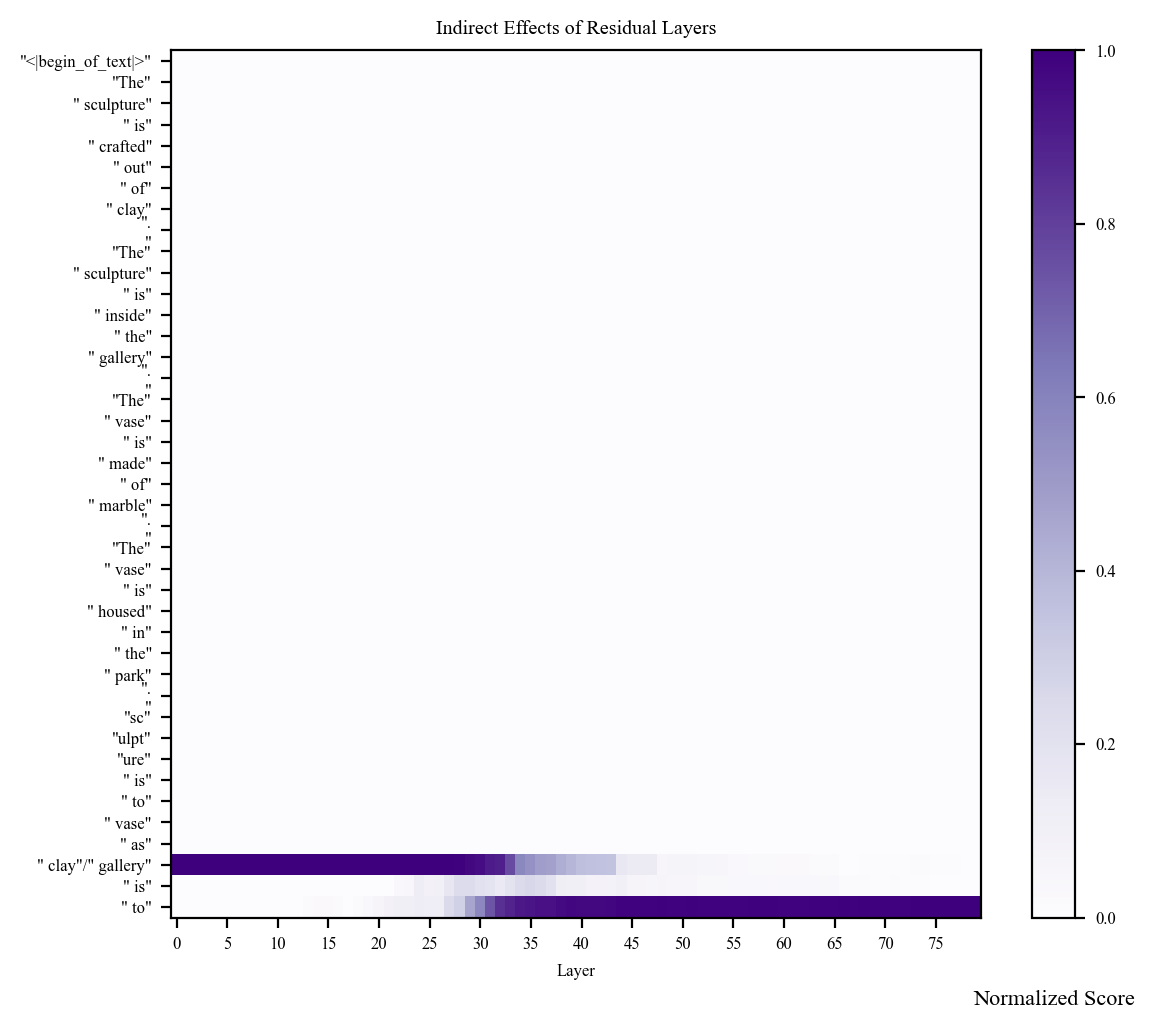

In [44]:
from src.visualization.patching import patching_heatmap

patching_heatmap(
    model,
    patched_activations,
    source_input_ids,
    base_input_ids,
    kind="residual"
)

## MLP Patching

In [4]:
import sys
sys.path.append("/disk/u/gio/mechinterp/analogies5")

from src.intervention.analysis import collect_activations_efficient, collect_logits

source_prompt = """The sculpture is crafted out of clay.
The sculpture is inside the gallery.
The vase is made of marble.
The vase is housed in the park.
sculpture is to vase as clay is to"""


source_mlp_activations = collect_activations_efficient(
    model,
    source_prompt,
    kind="mlp"
)
source_logits = collect_logits(
    model,
    source_prompt
)

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0


In [5]:
source_pred_id = source_logits[-1].argmax(dim=-1)
source_pred_tok = model.tokenizer.decode(source_pred_id)
print("Source Prediction:", source_pred_tok)

Source Prediction:  marble


In [6]:
base_prompt = """The sculpture is crafted out of clay.
The sculpture is inside the gallery.
The vase is made of marble.
The vase is housed in the park.
sculpture is to vase as gallery is to"""


base_mlp_activations = collect_activations_efficient(
    model,
    base_prompt,
    kind="mlp"
)
base_logits = collect_logits(
    model,
    base_prompt
)

In [7]:
base_pred_id = base_logits[-1].argmax(dim=-1)
base_pred_tok = model.tokenizer.decode(base_pred_id)
print("Base Prediction:", base_pred_tok)

Base Prediction:  park


In [8]:
source_target_logits = source_logits[-1][source_pred_id]
source_target_logits_base = base_logits[-1][source_pred_id]

total_logit_diff = source_target_logits - source_target_logits_base
print(f"{total_logit_diff=}")

total_logit_diff=tensor(8.0037, device='cuda:7')


In [9]:
source_input_ids = model.tokenizer.encode(source_prompt)
base_input_ids = model.tokenizer.encode(base_prompt)

assert len(source_input_ids) == len(base_input_ids)

In [10]:
from src.intervention.analysis import activation_patch

patched_mlp_activations = activation_patch(
    model,
    base_prompt,
    source_mlp_activations,
    target_token_id=source_pred_id,
    source_target_logits_base=source_target_logits_base,
    kind="mlp"
)

  0%|          | 0/80 [00:00<?, ?it/s]

100%|██████████| 80/80 [32:56<00:00, 24.71s/it]


In [11]:
# If patched_activations is a list of lists containing tensors
patched_mlp_activations = [
    [item.detach().cpu().numpy() if torch.is_tensor(item) else item for item in sublist]
    if isinstance(sublist, list) else 
    (sublist.detach().cpu().numpy() if torch.is_tensor(sublist) else sublist)
    for sublist in patched_mlp_activations
]

DEBUG:matplotlib:matplotlib data path: /disk/u/gio/.conda/envs/retrieval2/lib/python3.11/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/disk/u/gio/.config/matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:CACHEDIR=/disk/u/gio/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /disk/u/gio/.cache/matplotlib/fontlist-v390.json
Data range: min=-3.5803, max=2.4989
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching Times New Roman:style=normal:variant=normal:weight=normal:stretch=normal:size=6.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/disk/u/gio/.conda/envs/retrieval2/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic'

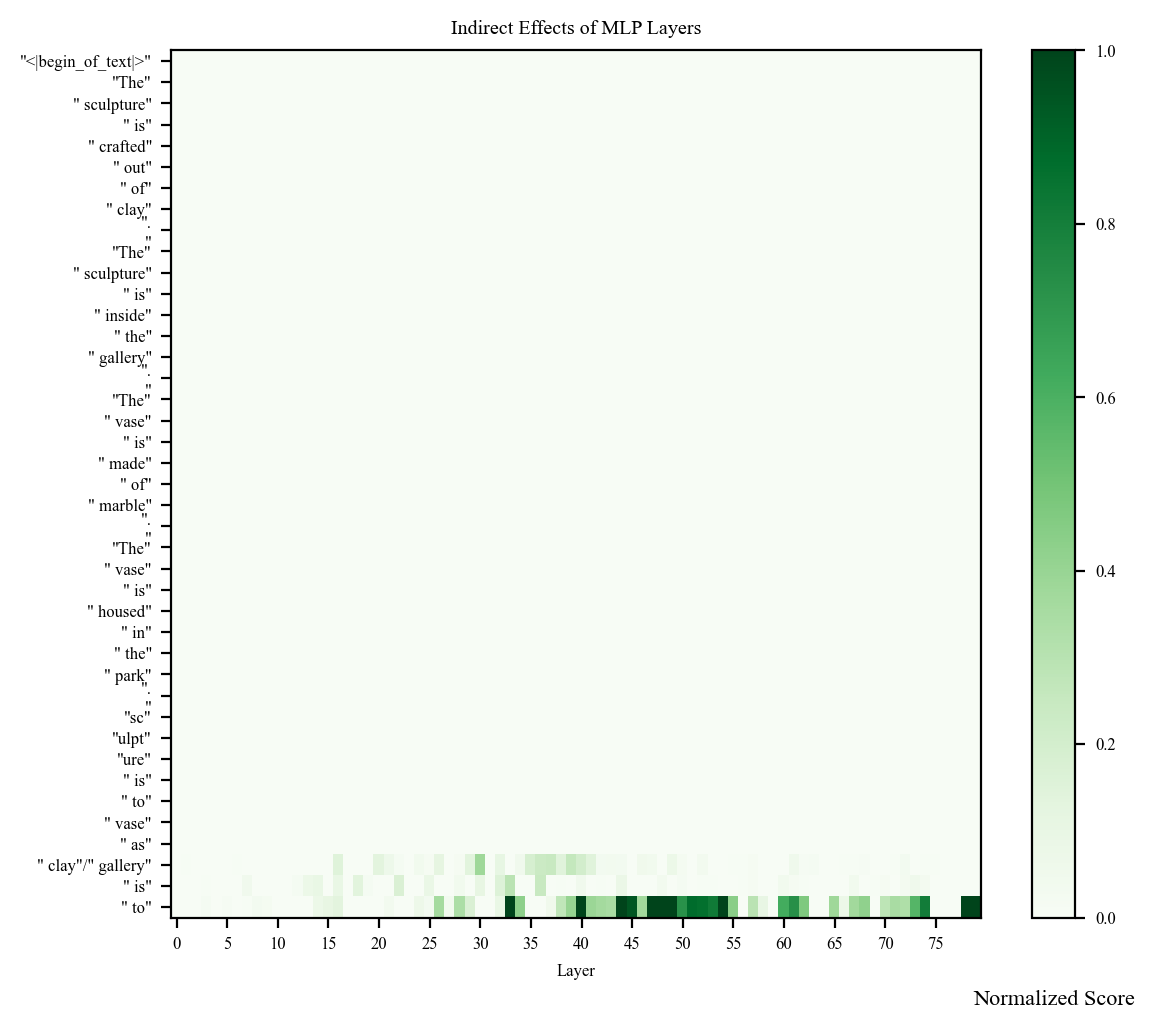

In [12]:
from src.visualization.patching import patching_heatmap

patching_heatmap(
    model,
    patched_mlp_activations,
    source_input_ids,
    base_input_ids,
    kind="mlp"
)

### Attention Patching

In [13]:
import sys
sys.path.append("/disk/u/gio/mechinterp/analogies5")

from src.intervention.analysis import collect_activations, collect_logits

source_prompt = """The sculpture is crafted out of clay.
The sculpture is inside the gallery.
The vase is made of marble.
The vase is housed in the park.
sculpture is to vase as clay is to"""


source_attn_activations = collect_activations(
    model,
    source_prompt,
    kind="attention"
)

source_logits = collect_logits(
    model,
    source_prompt
)

100%|██████████| 80/80 [00:47<00:00,  1.70it/s]


In [14]:
source_pred_id = source_logits[-1].argmax(dim=-1)
source_pred_tok = model.tokenizer.decode(source_pred_id)
print("Source Prediction:", source_pred_tok)

Source Prediction:  marble


In [15]:
base_prompt = """The sculpture is crafted out of clay.
The sculpture is inside the gallery.
The vase is made of marble.
The vase is housed in the park.
sculpture is to vase as gallery is to"""


base_attn_activations = collect_activations(
    model,
    base_prompt,
    kind="attention"
)
base_logits = collect_logits(
    model,
    base_prompt
)

  0%|          | 0/80 [00:00<?, ?it/s]

100%|██████████| 80/80 [00:47<00:00,  1.70it/s]


In [16]:
base_pred_id = base_logits[-1].argmax(dim=-1)
base_pred_tok = model.tokenizer.decode(base_pred_id)
print("Base Prediction:", base_pred_tok)

Base Prediction:  park


In [17]:
source_target_logits = source_logits[-1][source_pred_id]
source_target_logits_base = base_logits[-1][source_pred_id]

total_logit_diff = source_target_logits - source_target_logits_base
print(f"{total_logit_diff=}")

total_logit_diff=tensor(8.0037, device='cuda:7')


In [18]:
source_input_ids = model.tokenizer.encode(source_prompt)
base_input_ids = model.tokenizer.encode(base_prompt)

assert len(source_input_ids) == len(base_input_ids)

In [20]:
from src.intervention.analysis import activation_patch

patched_attn_activations = activation_patch(
    model,
    base_prompt,
    source_attn_activations,
    target_token_id=source_pred_id,
    source_target_logits_base=source_target_logits_base,
    kind="attention"
)

All Layers: 100%|██████████| 80/80 [33:06<00:00, 24.83s/it]


In [21]:
# If patched_activations is a list of lists containing tensors
patched_attn_activations = [
    [item.detach().cpu().numpy() if torch.is_tensor(item) else item for item in sublist]
    if isinstance(sublist, list) else 
    (sublist.detach().cpu().numpy() if torch.is_tensor(sublist) else sublist)
    for sublist in patched_attn_activations
]

Data range: min=-3.3054, max=5.6087
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7fec467eb090>
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


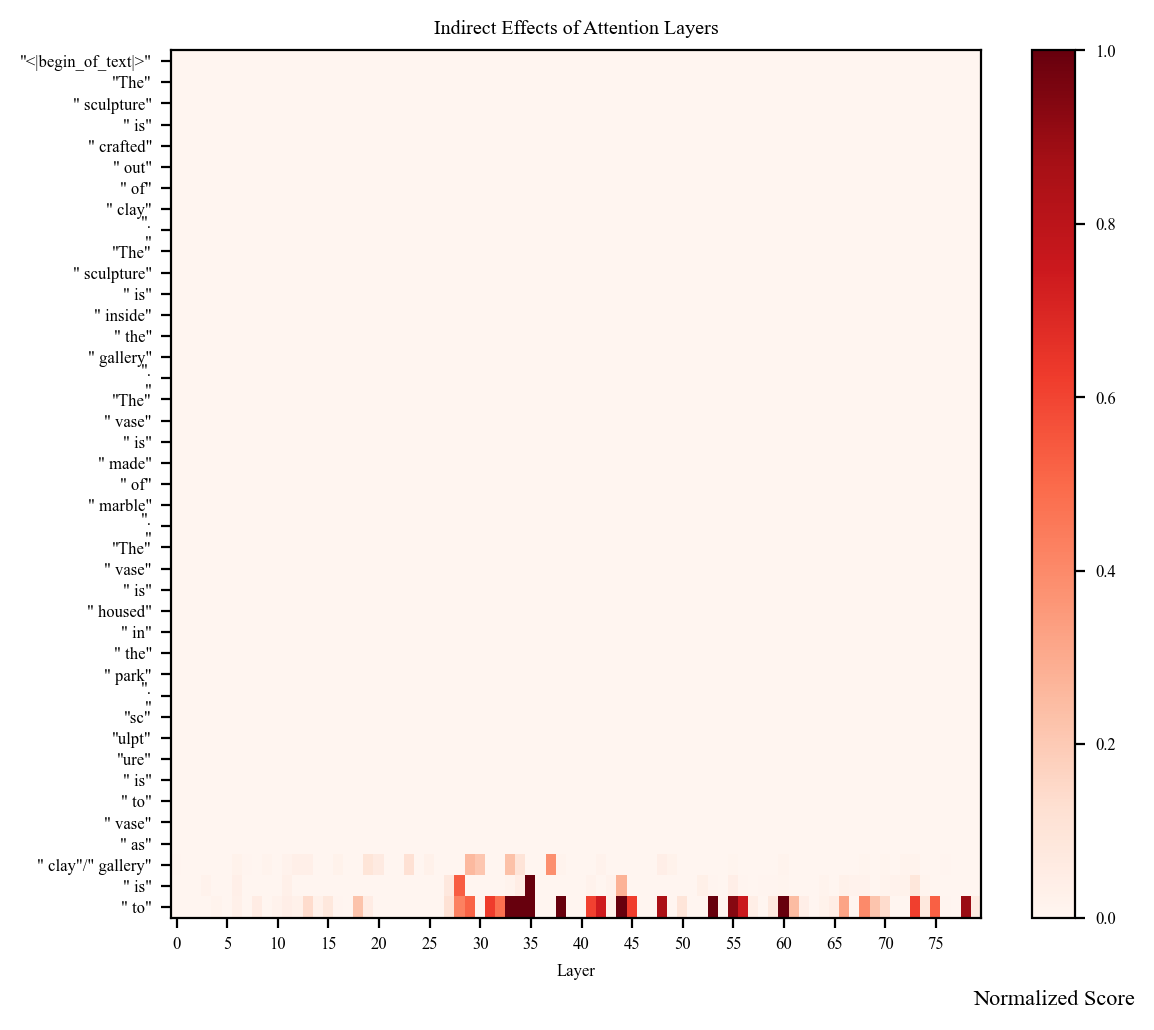

In [22]:
from src.visualization.patching import patching_heatmap

patching_heatmap(
    model,
    patched_attn_activations,
    source_input_ids,
    base_input_ids,
    kind="attention"
)